# Generate stitchiing list

In [1]:
import os
import numpy as np
import pandas as pd
from scipy.sparse import coo_matrix
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm


In [2]:
input_path = '/home/unix/jiahao/wanglab/Data/Analyzed/2024-01-08-Jiakun-MouseSpleen64Gene/documents/maf-single-sample/'
maf_files = sorted(os.listdir(input_path))

In [3]:
def generate_stitching_order(maf_file_path, output_path):
    
    df = pd.read_xml(maf_file_path)
    df = df.loc[:, ["StageXPos", "StageYPos", "PositionID"]]
    
    # get the steps 
    temp = df['StageYPos'].shift(-1) - df['StageYPos']
    step = pd.value_counts(temp).index.values[0]
    
    # get the relative positions
    point_relative_min = [df.loc[:,'StageXPos'].min(), df.loc[:,'StageYPos'].min()]
    point_relative_max = [df.loc[:,'StageXPos'].max(), df.loc[:,'StageYPos'].max()]
    coo_shape = np.array(point_relative_max) - np.array(point_relative_min)
    coo_shape = (coo_shape / step + 0.5 + 1).astype(int)
    df['relative_x'] = np.array((df['StageXPos'] - point_relative_min[0])/step + 0.5, dtype=int)
    df['relative_y'] = np.array((df['StageYPos'] - point_relative_min[1])/step + 0.5, dtype=int)
    df = df.loc[:, ['PositionID', 'relative_x', 'relative_y']]
    
    # construct coo matrix
    value = df.loc[:,'PositionID'].values
    row = df.loc[:,'relative_y'].values
    col = df.loc[:,'relative_x'].values
    matrix_shape = [coo_shape[1], coo_shape[0]]

    ordering_matrix = coo_matrix((value, (row,col)), shape=matrix_shape).toarray()

    ## Warning 
    ordering_matrix = np.rot90(ordering_matrix)
    ordering_matrix = np.flip(ordering_matrix, axis=1)
    
    ordering_df = pd.DataFrame(ordering_matrix)
    ordering_list = ordering_df.unstack(1)
    output_df = pd.DataFrame(ordering_list)
    output_df = output_df.reset_index()
    output_df.columns = ["col", "row", "id"]
    output_df['grid'] = "tile_" + output_df['row'].astype(str) + "_" + output_df['col'].astype(str)

    fig, ax = plt.subplots(figsize=(max(row), max(col)))
    plt.imshow(ordering_matrix > 0)
    plt.xticks(np.arange(-0.5, max(row)+0.5, 1.0))
    plt.yticks(np.arange(-0.5, max(col)+0.5, 1.0))
    plt.grid()
    
    for i in range(output_df.shape[0]):
        plt.text(output_df.iloc[i, 0]-0.1, output_df.iloc[i, 1]-0.1, output_df.iloc[i, 2], color='blue', size=10)
        plt.text(output_df.iloc[i, 0]-0.25, output_df.iloc[i, 1]+0.1, output_df.iloc[i, 3], color='blue', size=10)

    for tick in ax.xaxis.get_major_ticks():
        tick.tick1line.set_visible(False)
        tick.tick2line.set_visible(False)
        tick.label1.set_visible(False)
        tick.label2.set_visible(False)

    for tick in ax.yaxis.get_major_ticks():
        tick.tick1line.set_visible(False)
        tick.tick2line.set_visible(False)
        tick.label1.set_visible(False)
        tick.label2.set_visible(False)
    plt.tight_layout()
    plt.savefig(os.path.join(output_path))
    plt.show()

    return output_df

  0%|          | 0/1 [00:00<?, ?it/s]

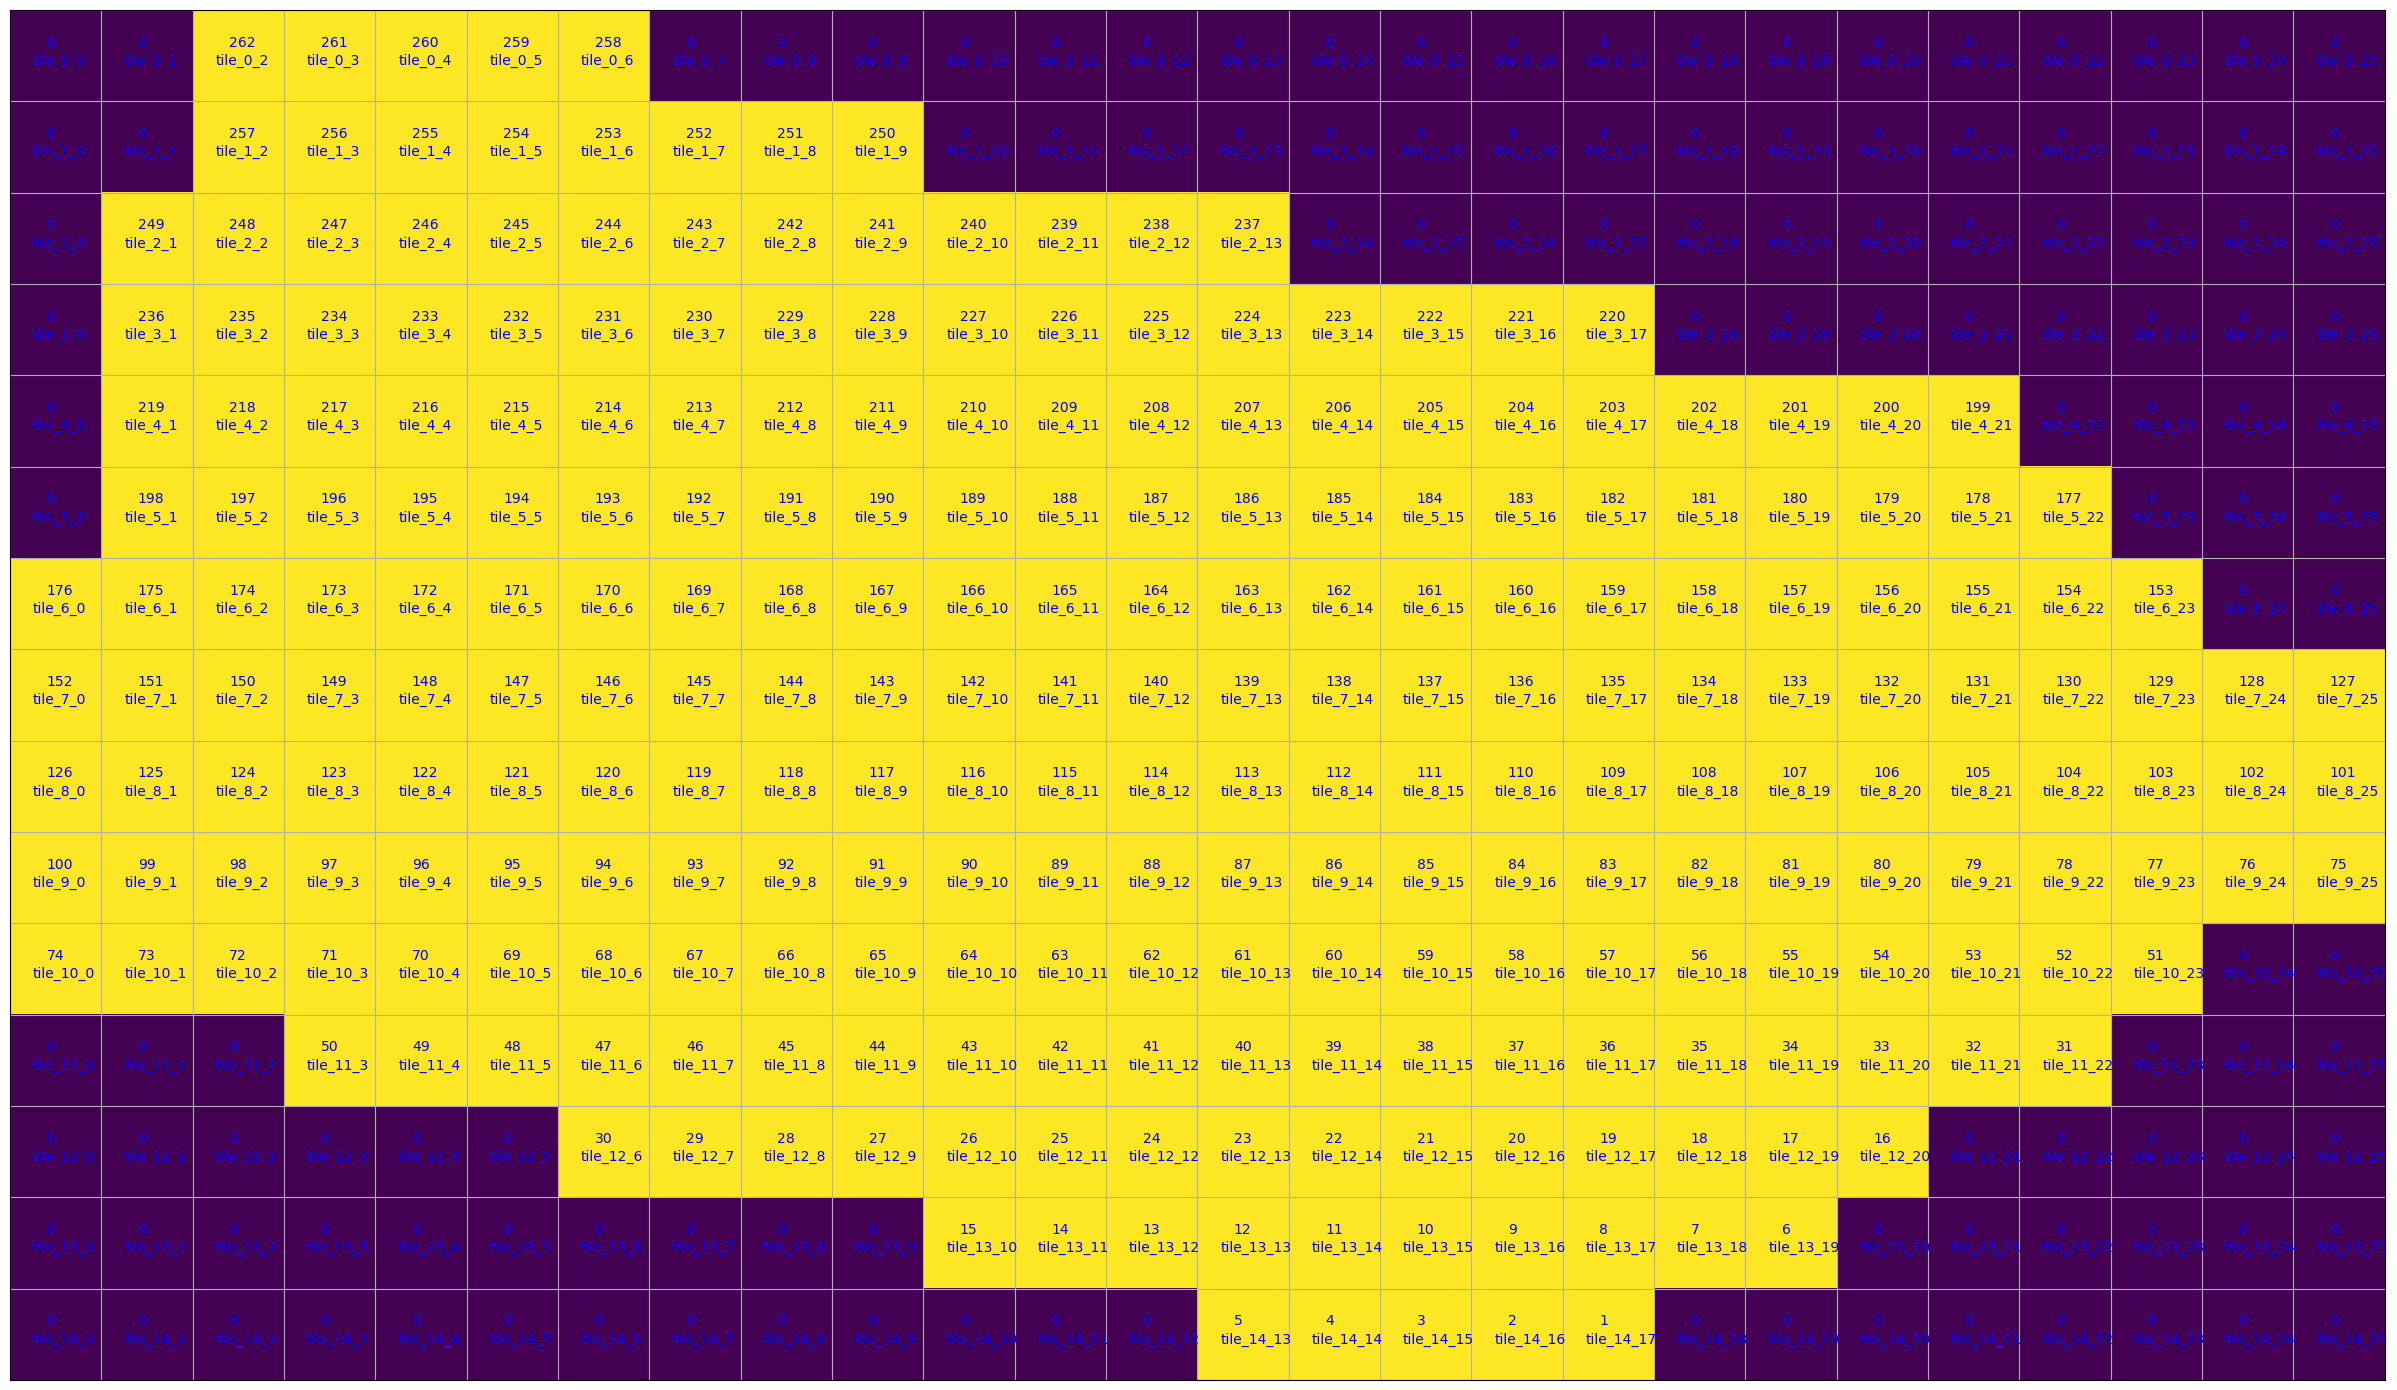

In [14]:
output_path = '/home/unix/jiahao/wanglab/Data/Analyzed/2024-01-08-Jiakun-MouseSpleen64Gene/images/fused'
for i in tqdm(maf_files[:1]):
    current_sample = i.split('.')[0]
    current_output_path = os.path.join(output_path, current_sample)
    if not os.path.exists(current_output_path):
        os.mkdir(current_output_path)
    
    df = generate_stitching_order(os.path.join(input_path, i), current_output_path)


In [13]:
from tifffile import imwrite

x, y, z = [1496, 1496, 35]
output_dir = '/home/unix/jiahao/wanglab/Data/Analyzed/2024-01-08-Jiakun-MouseSpleen64Gene/images/fused'
if not os.path.exists(output_dir):
    os.mkdir(output_dir)
    

# Create blank tile
blank_2d = np.zeros((x, y), dtype=np.uint8)
blank_3d = np.zeros((z, x, y), dtype=np.uint8)

# Save blank tile to output directory
imwrite(os.path.join(output_dir, "2D", 'blank.tif'), blank_2d)
imwrite(os.path.join(output_dir, "3D", 'blank.tif'), blank_3d)

  0%|          | 0/6 [00:00<?, ?it/s]

sample1


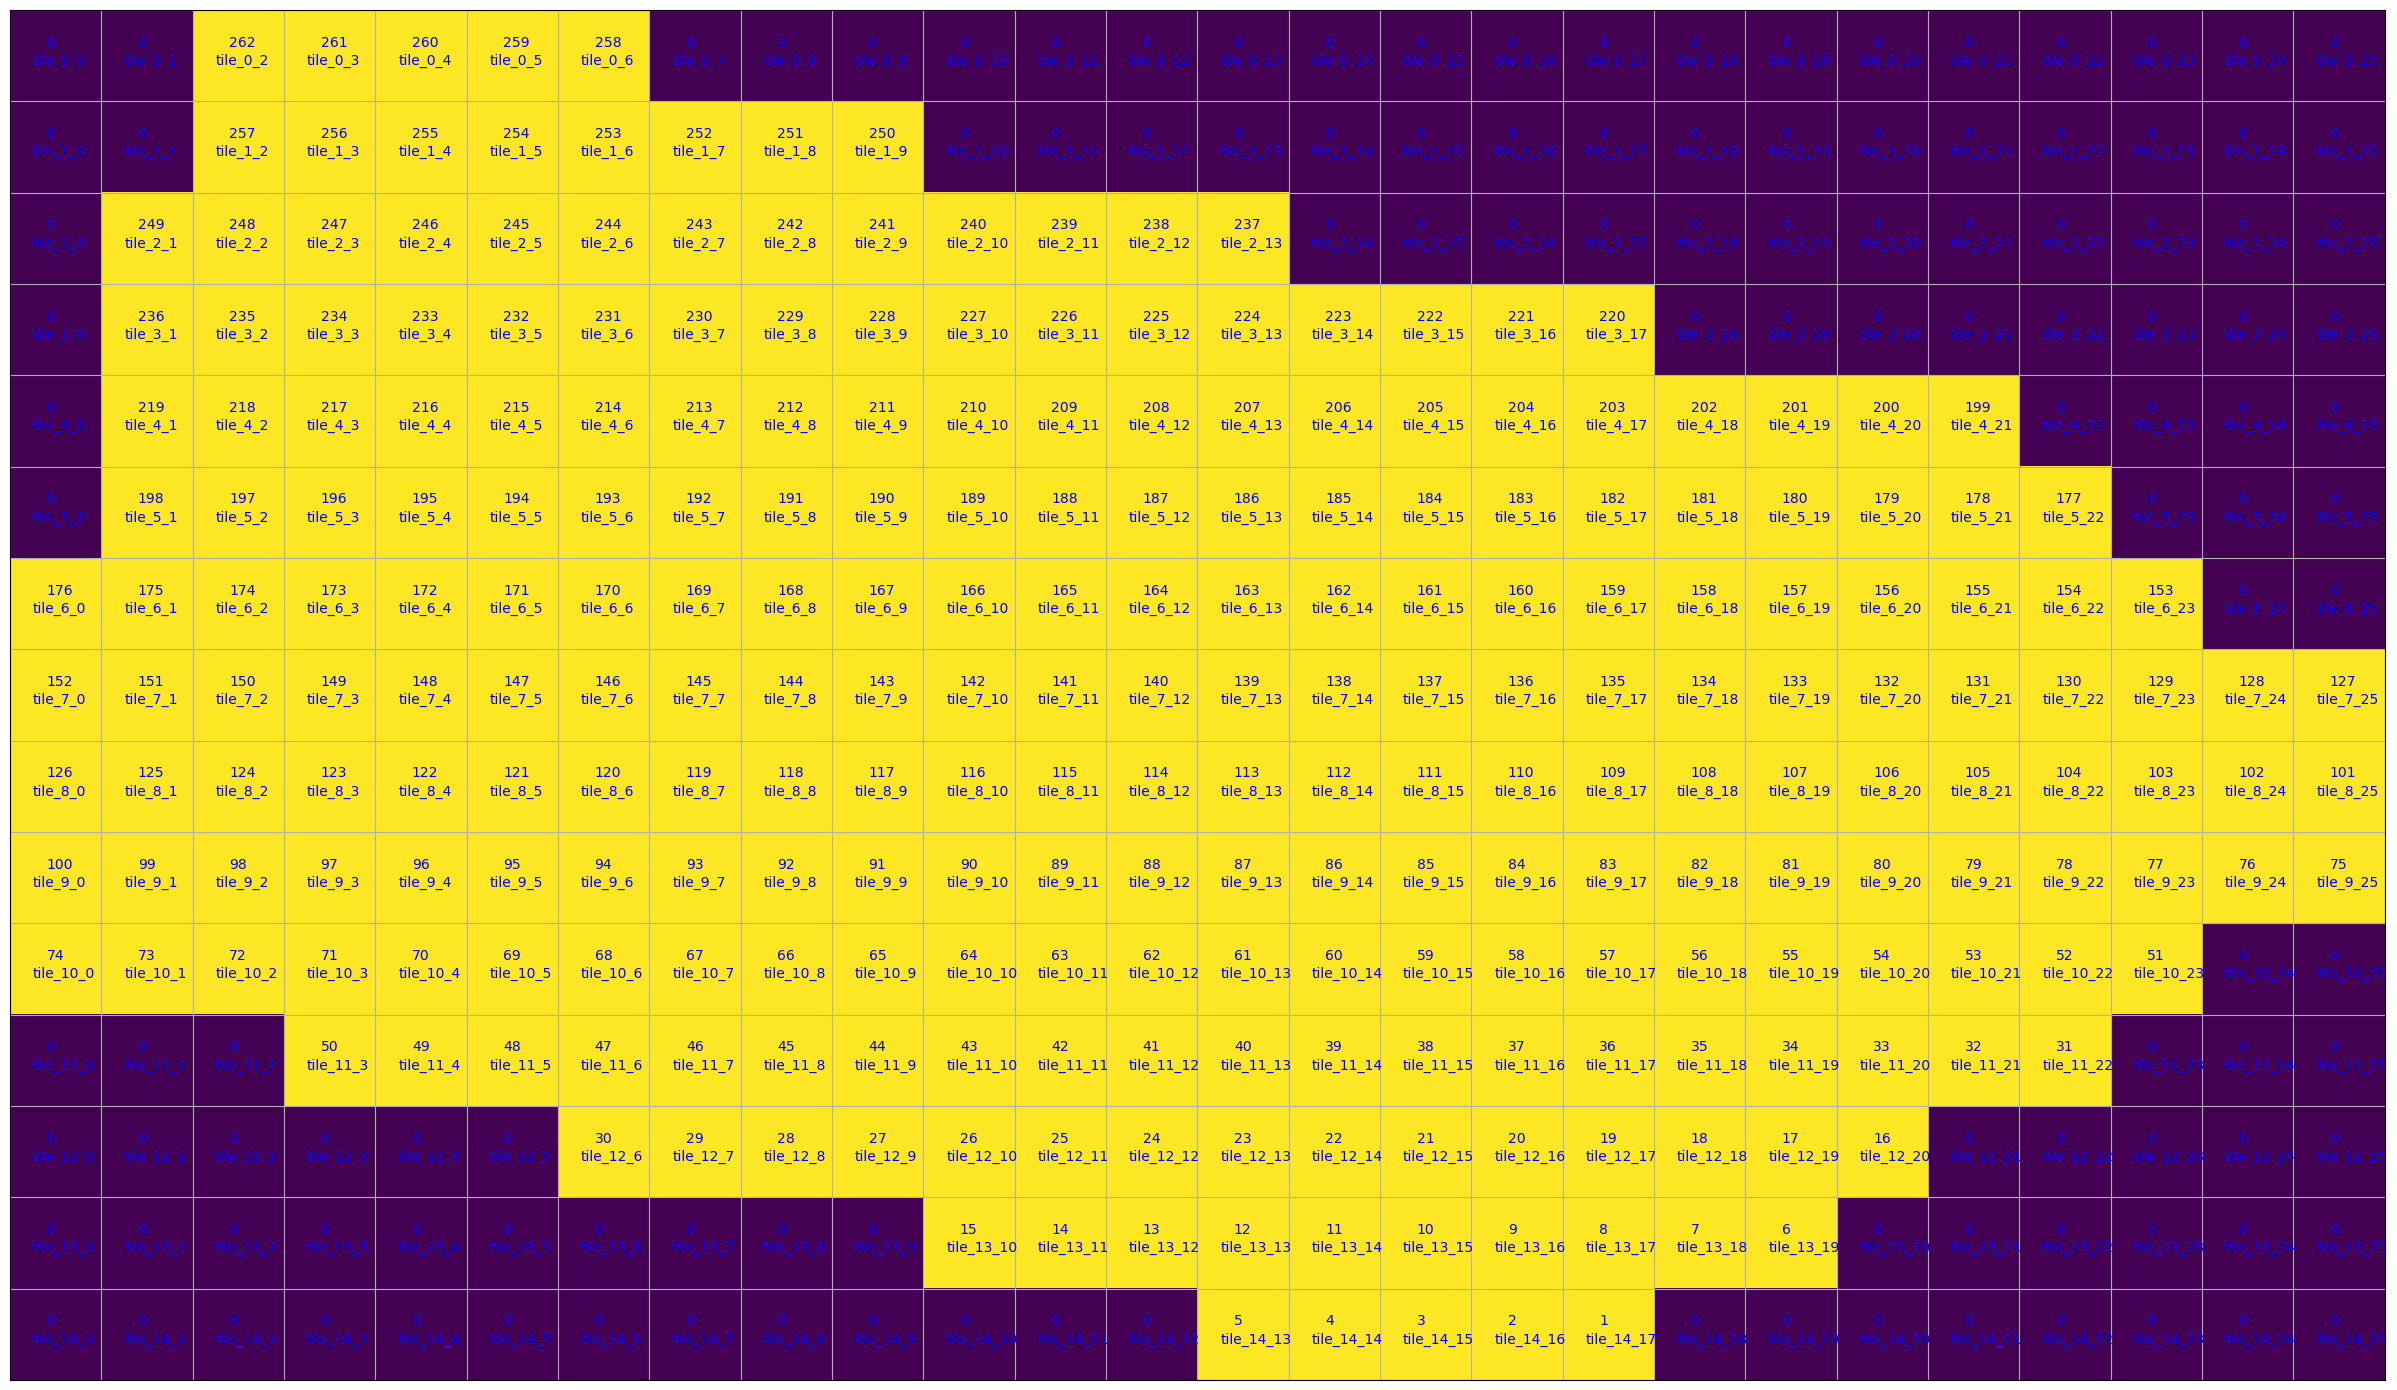

  0%|          | 0/390 [00:00<?, ?it/s]

sample2


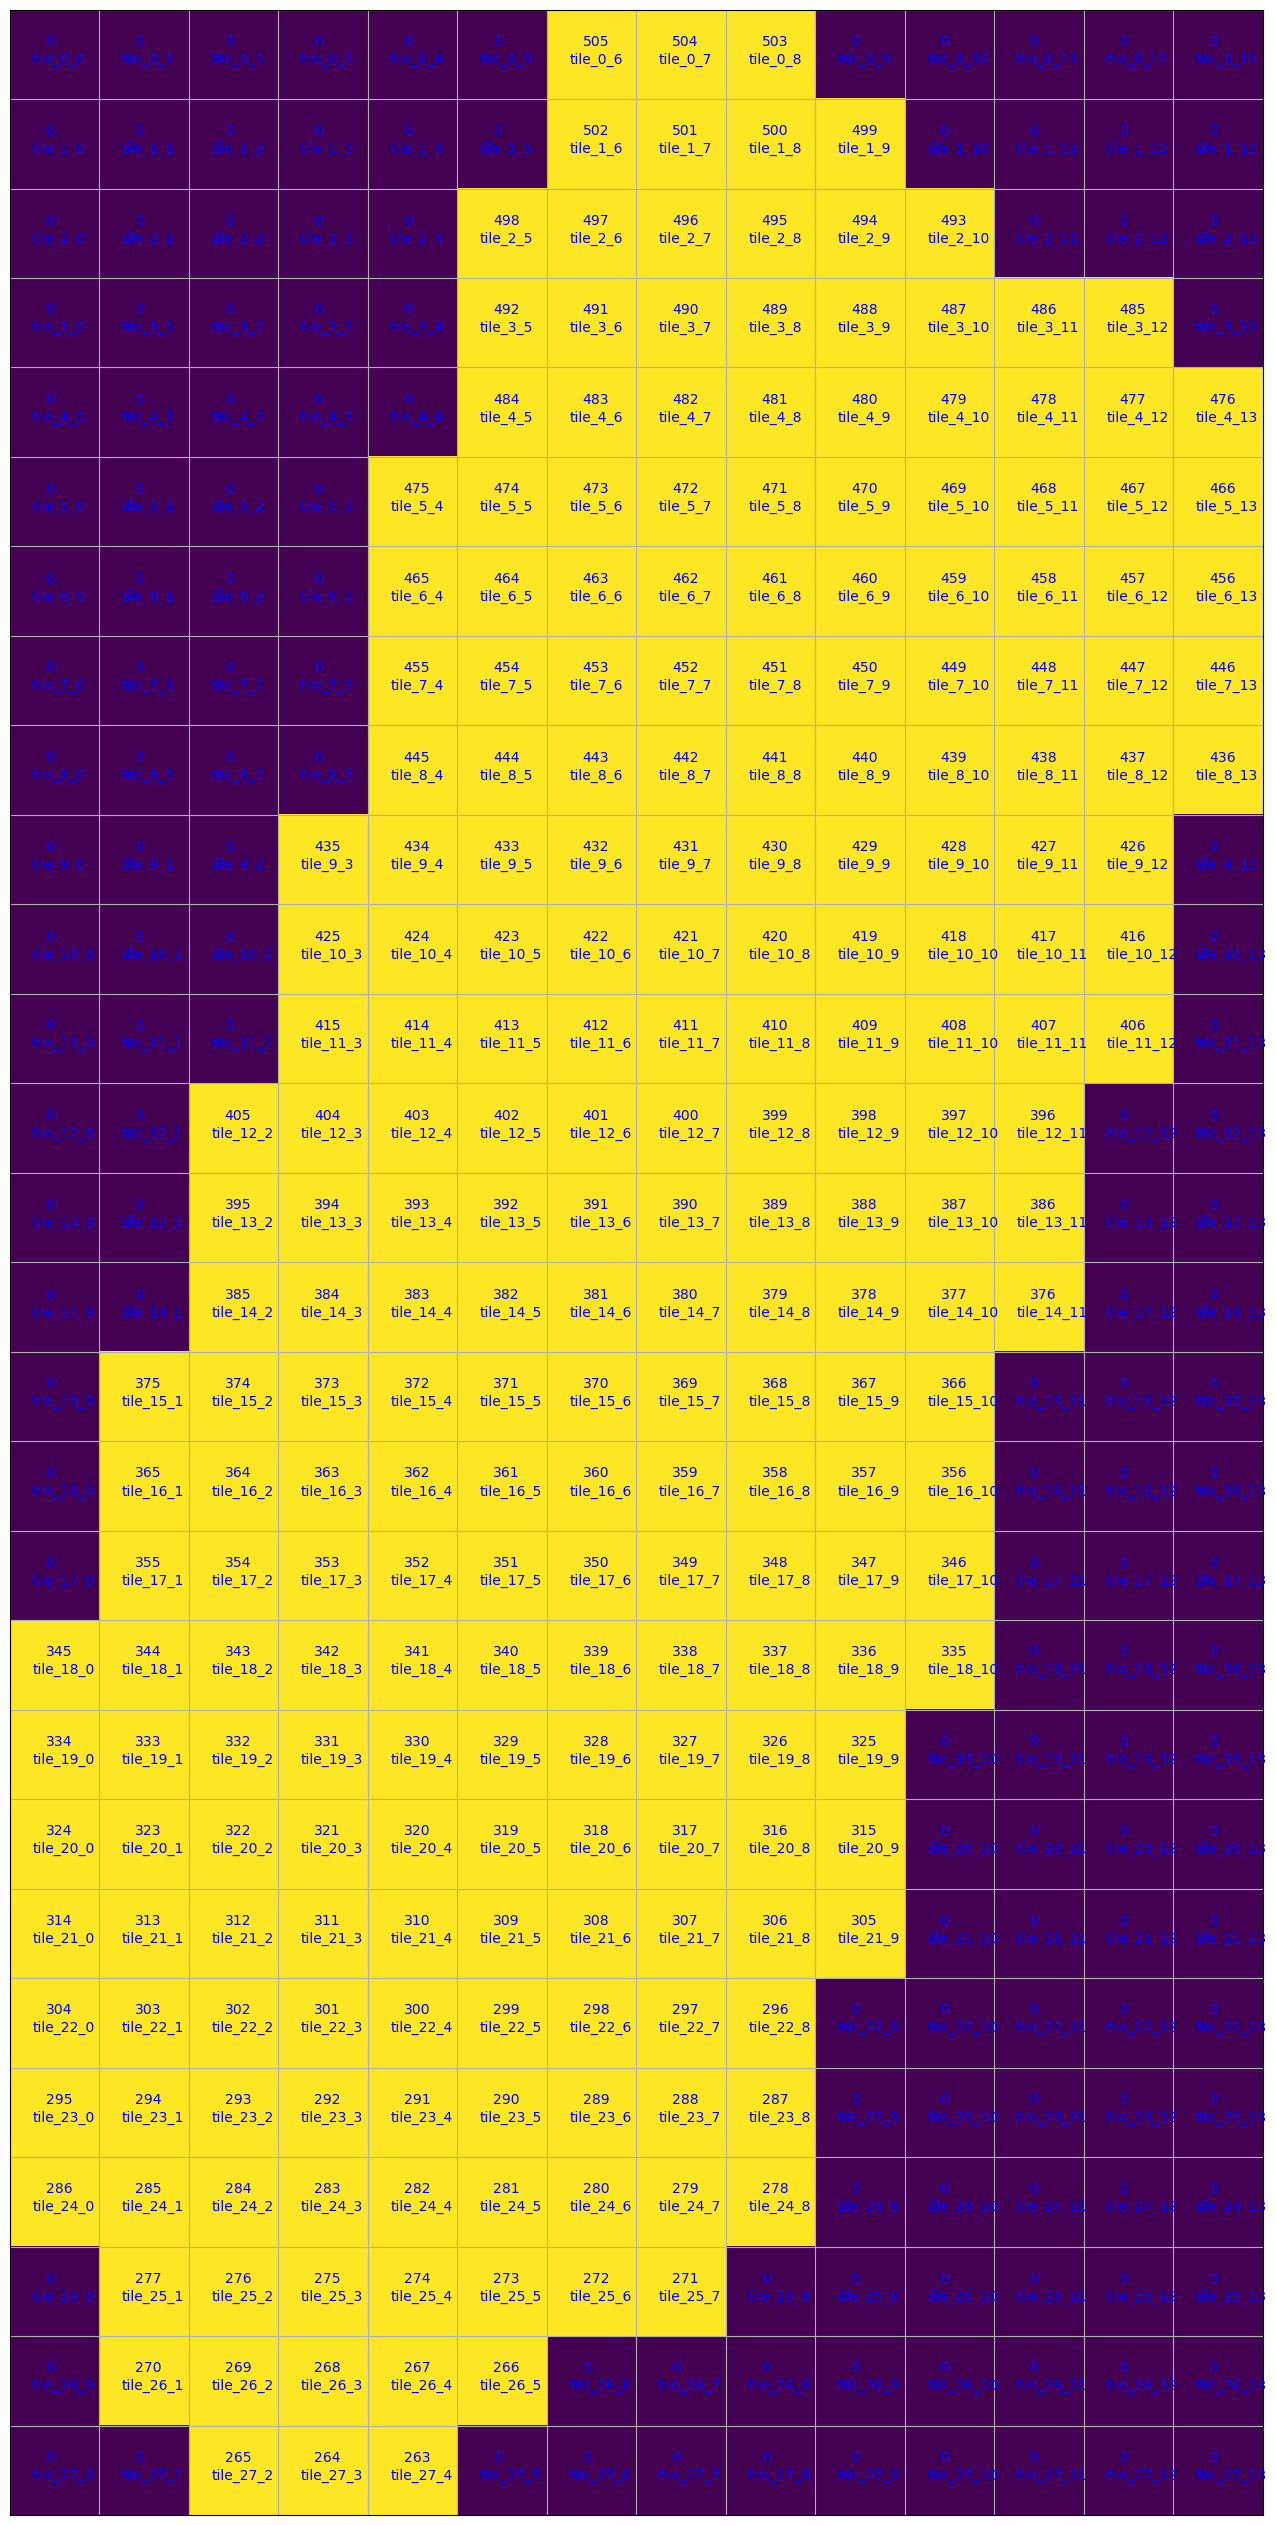

  0%|          | 0/392 [00:00<?, ?it/s]

sample3


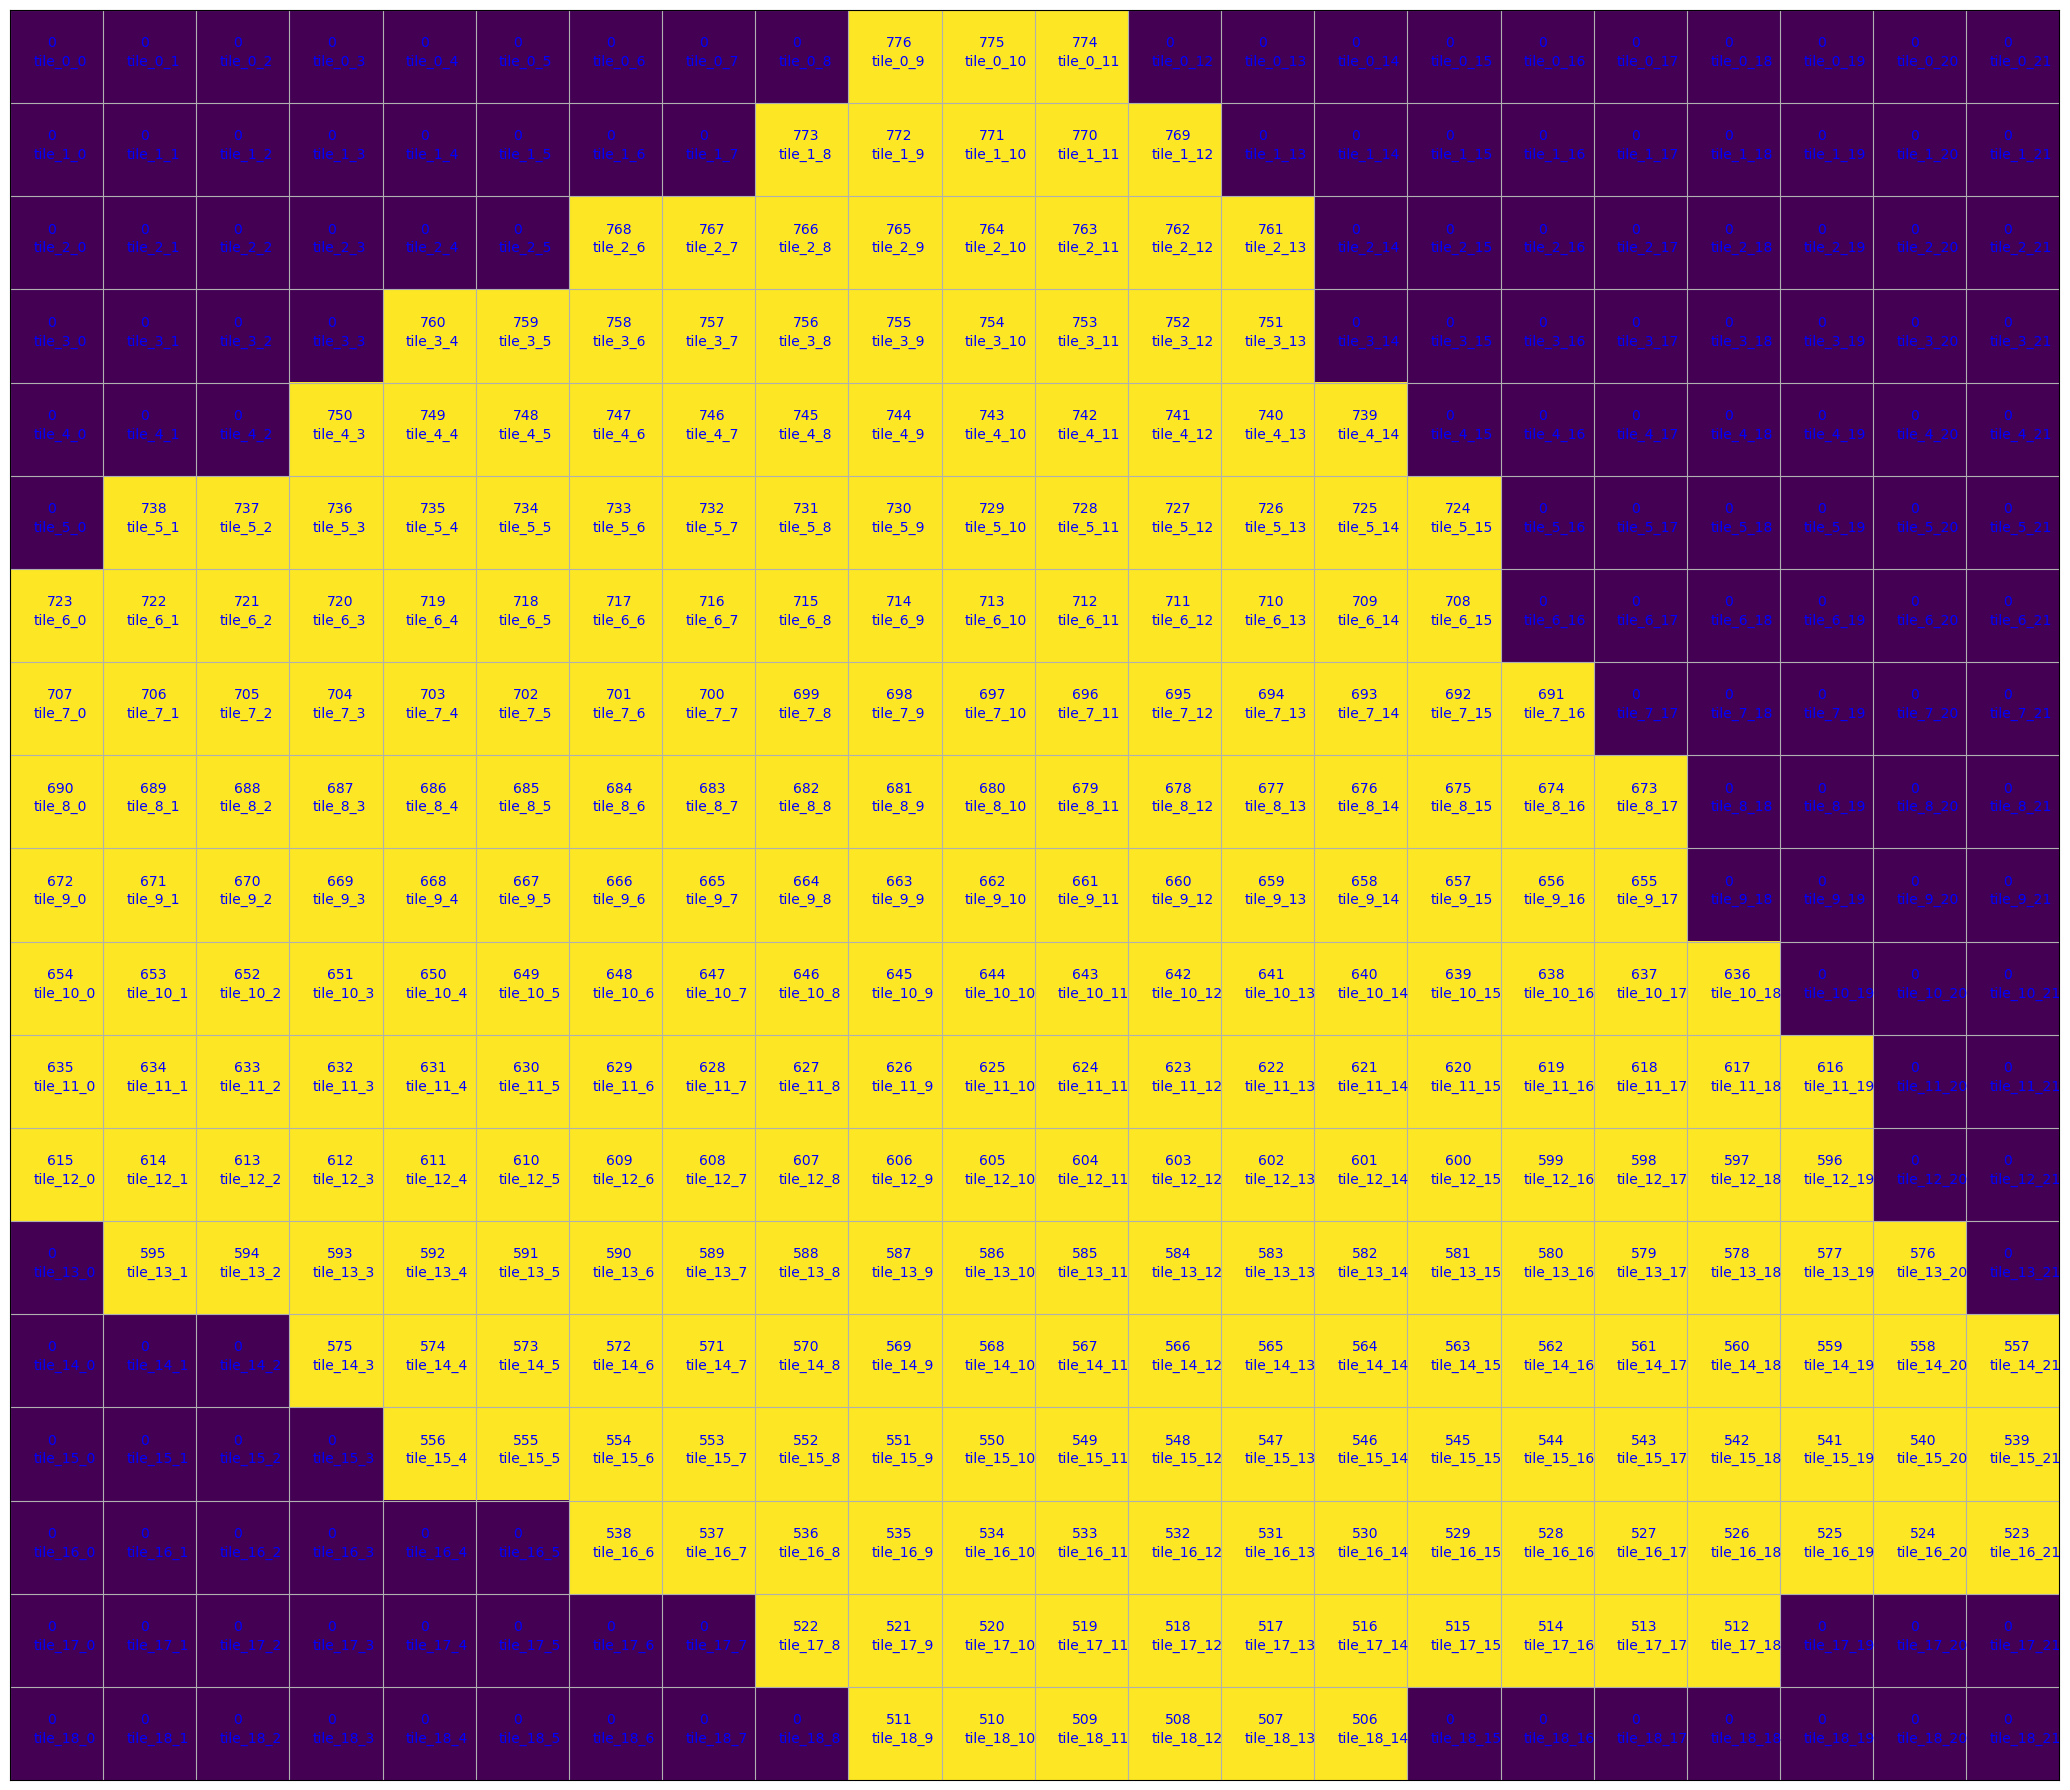

  0%|          | 0/418 [00:00<?, ?it/s]

sample4


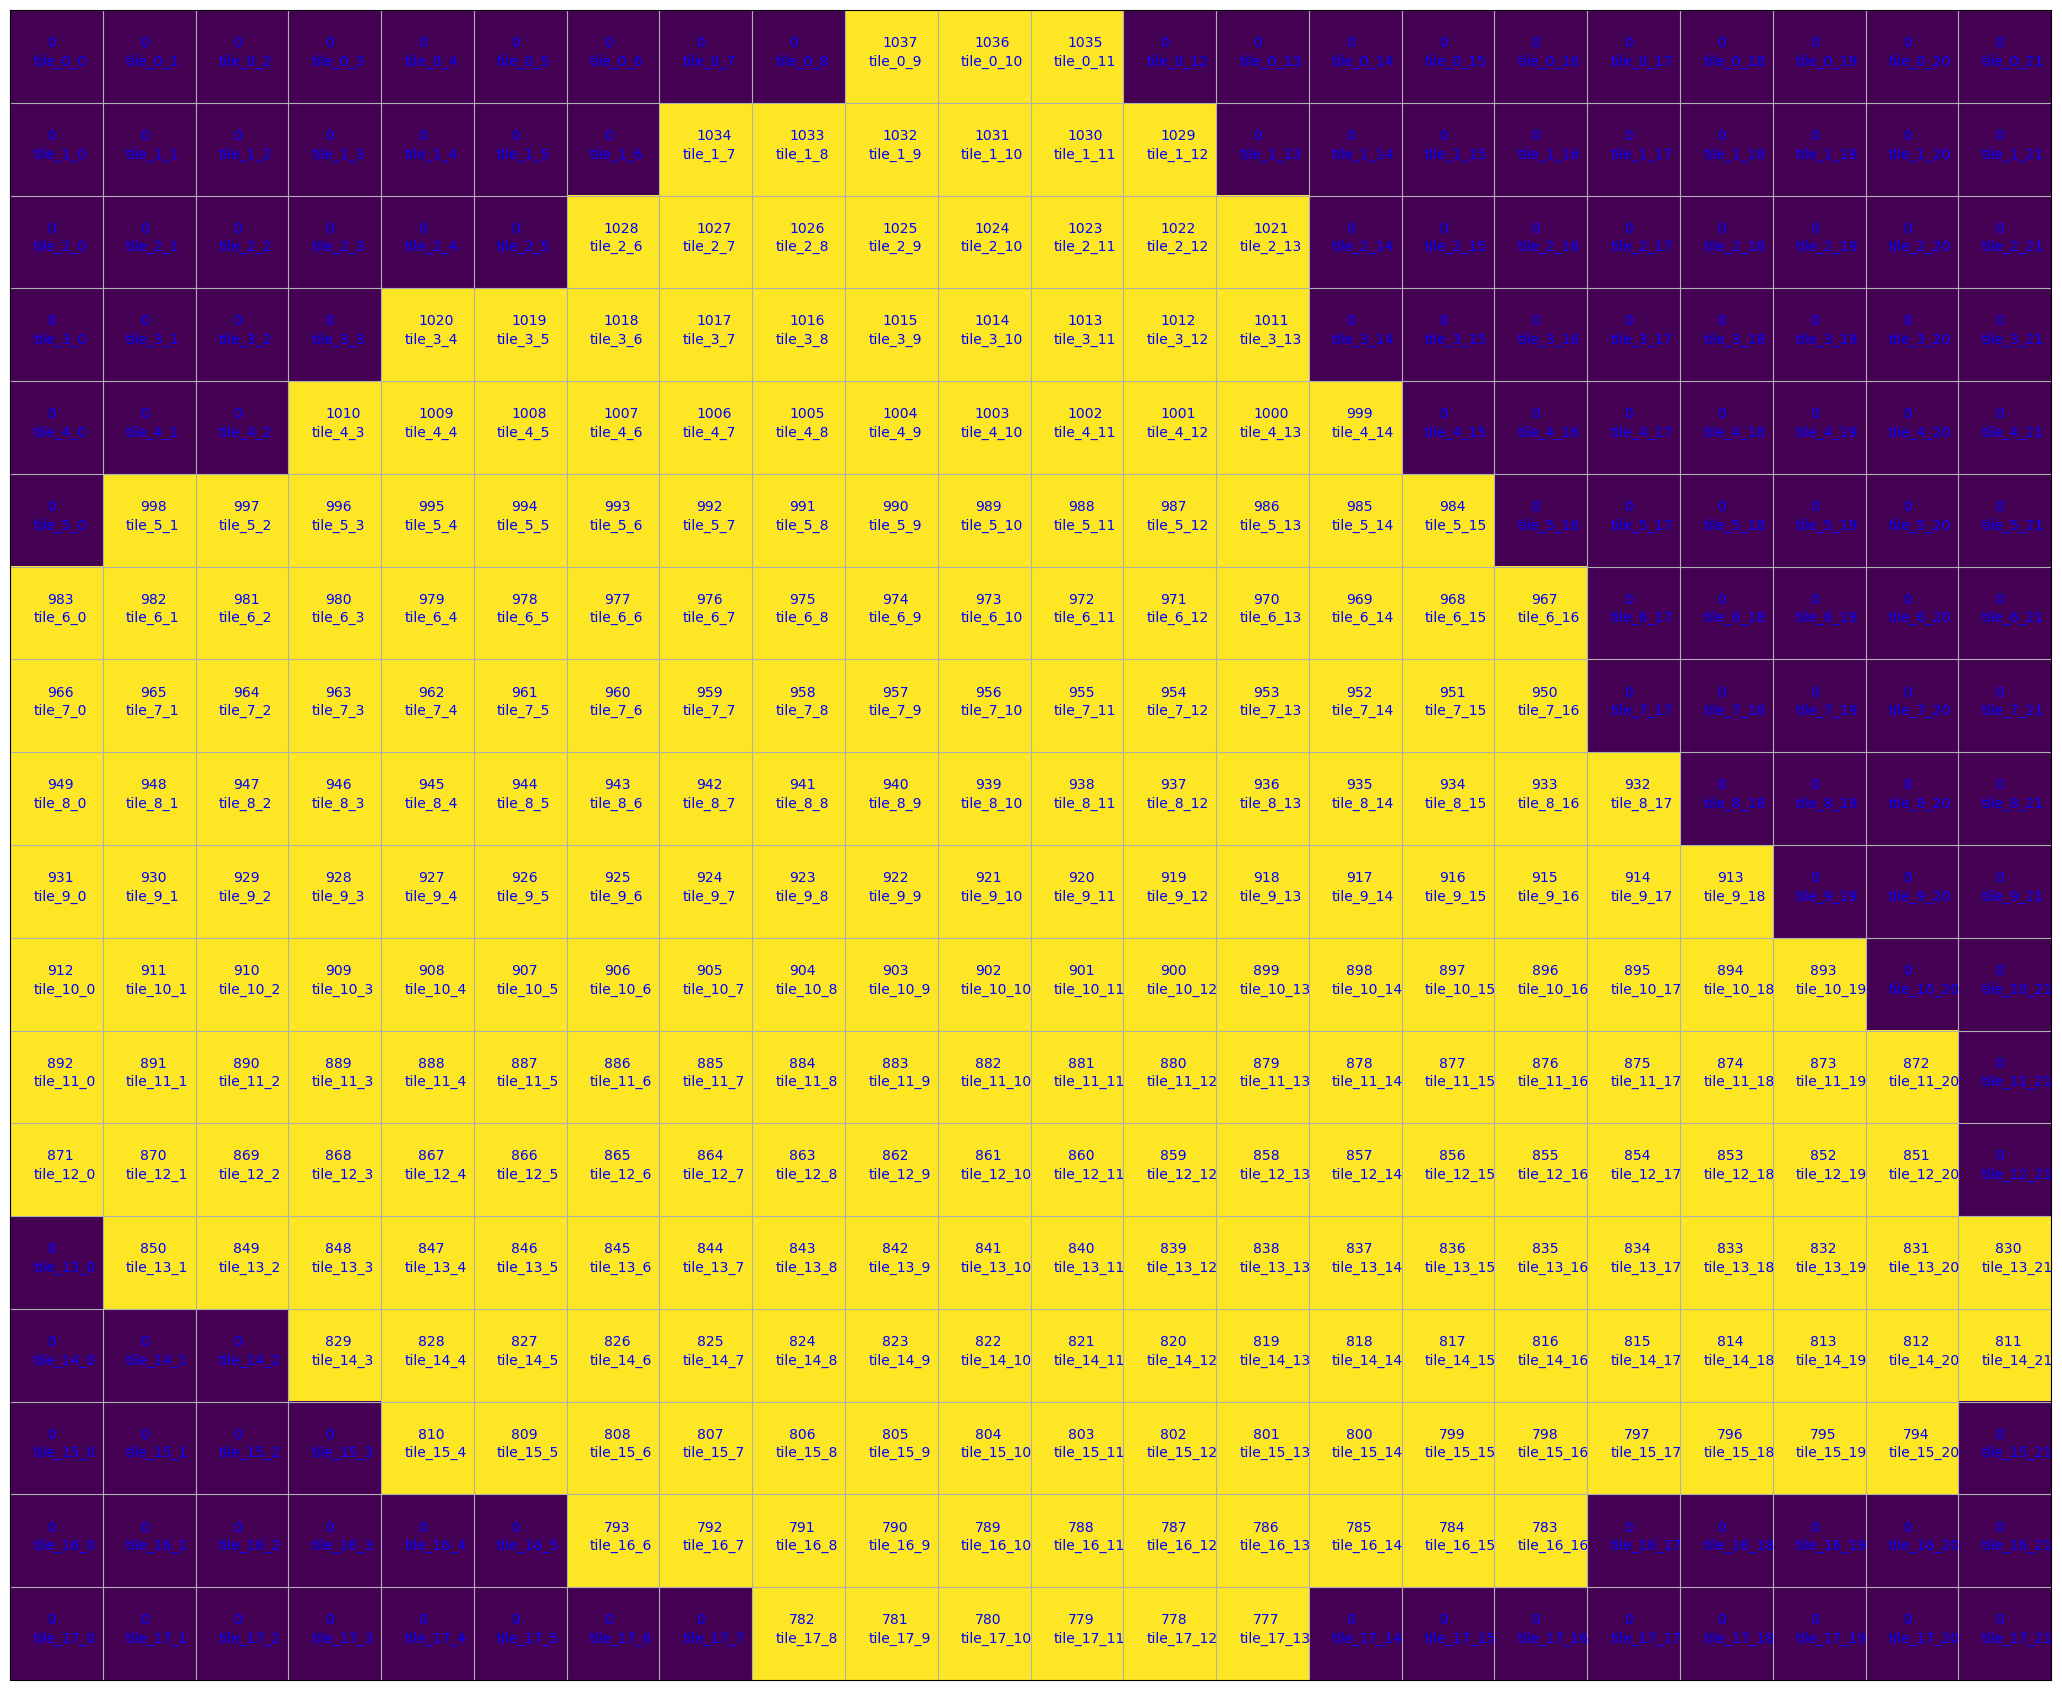

  0%|          | 0/396 [00:00<?, ?it/s]

sample5


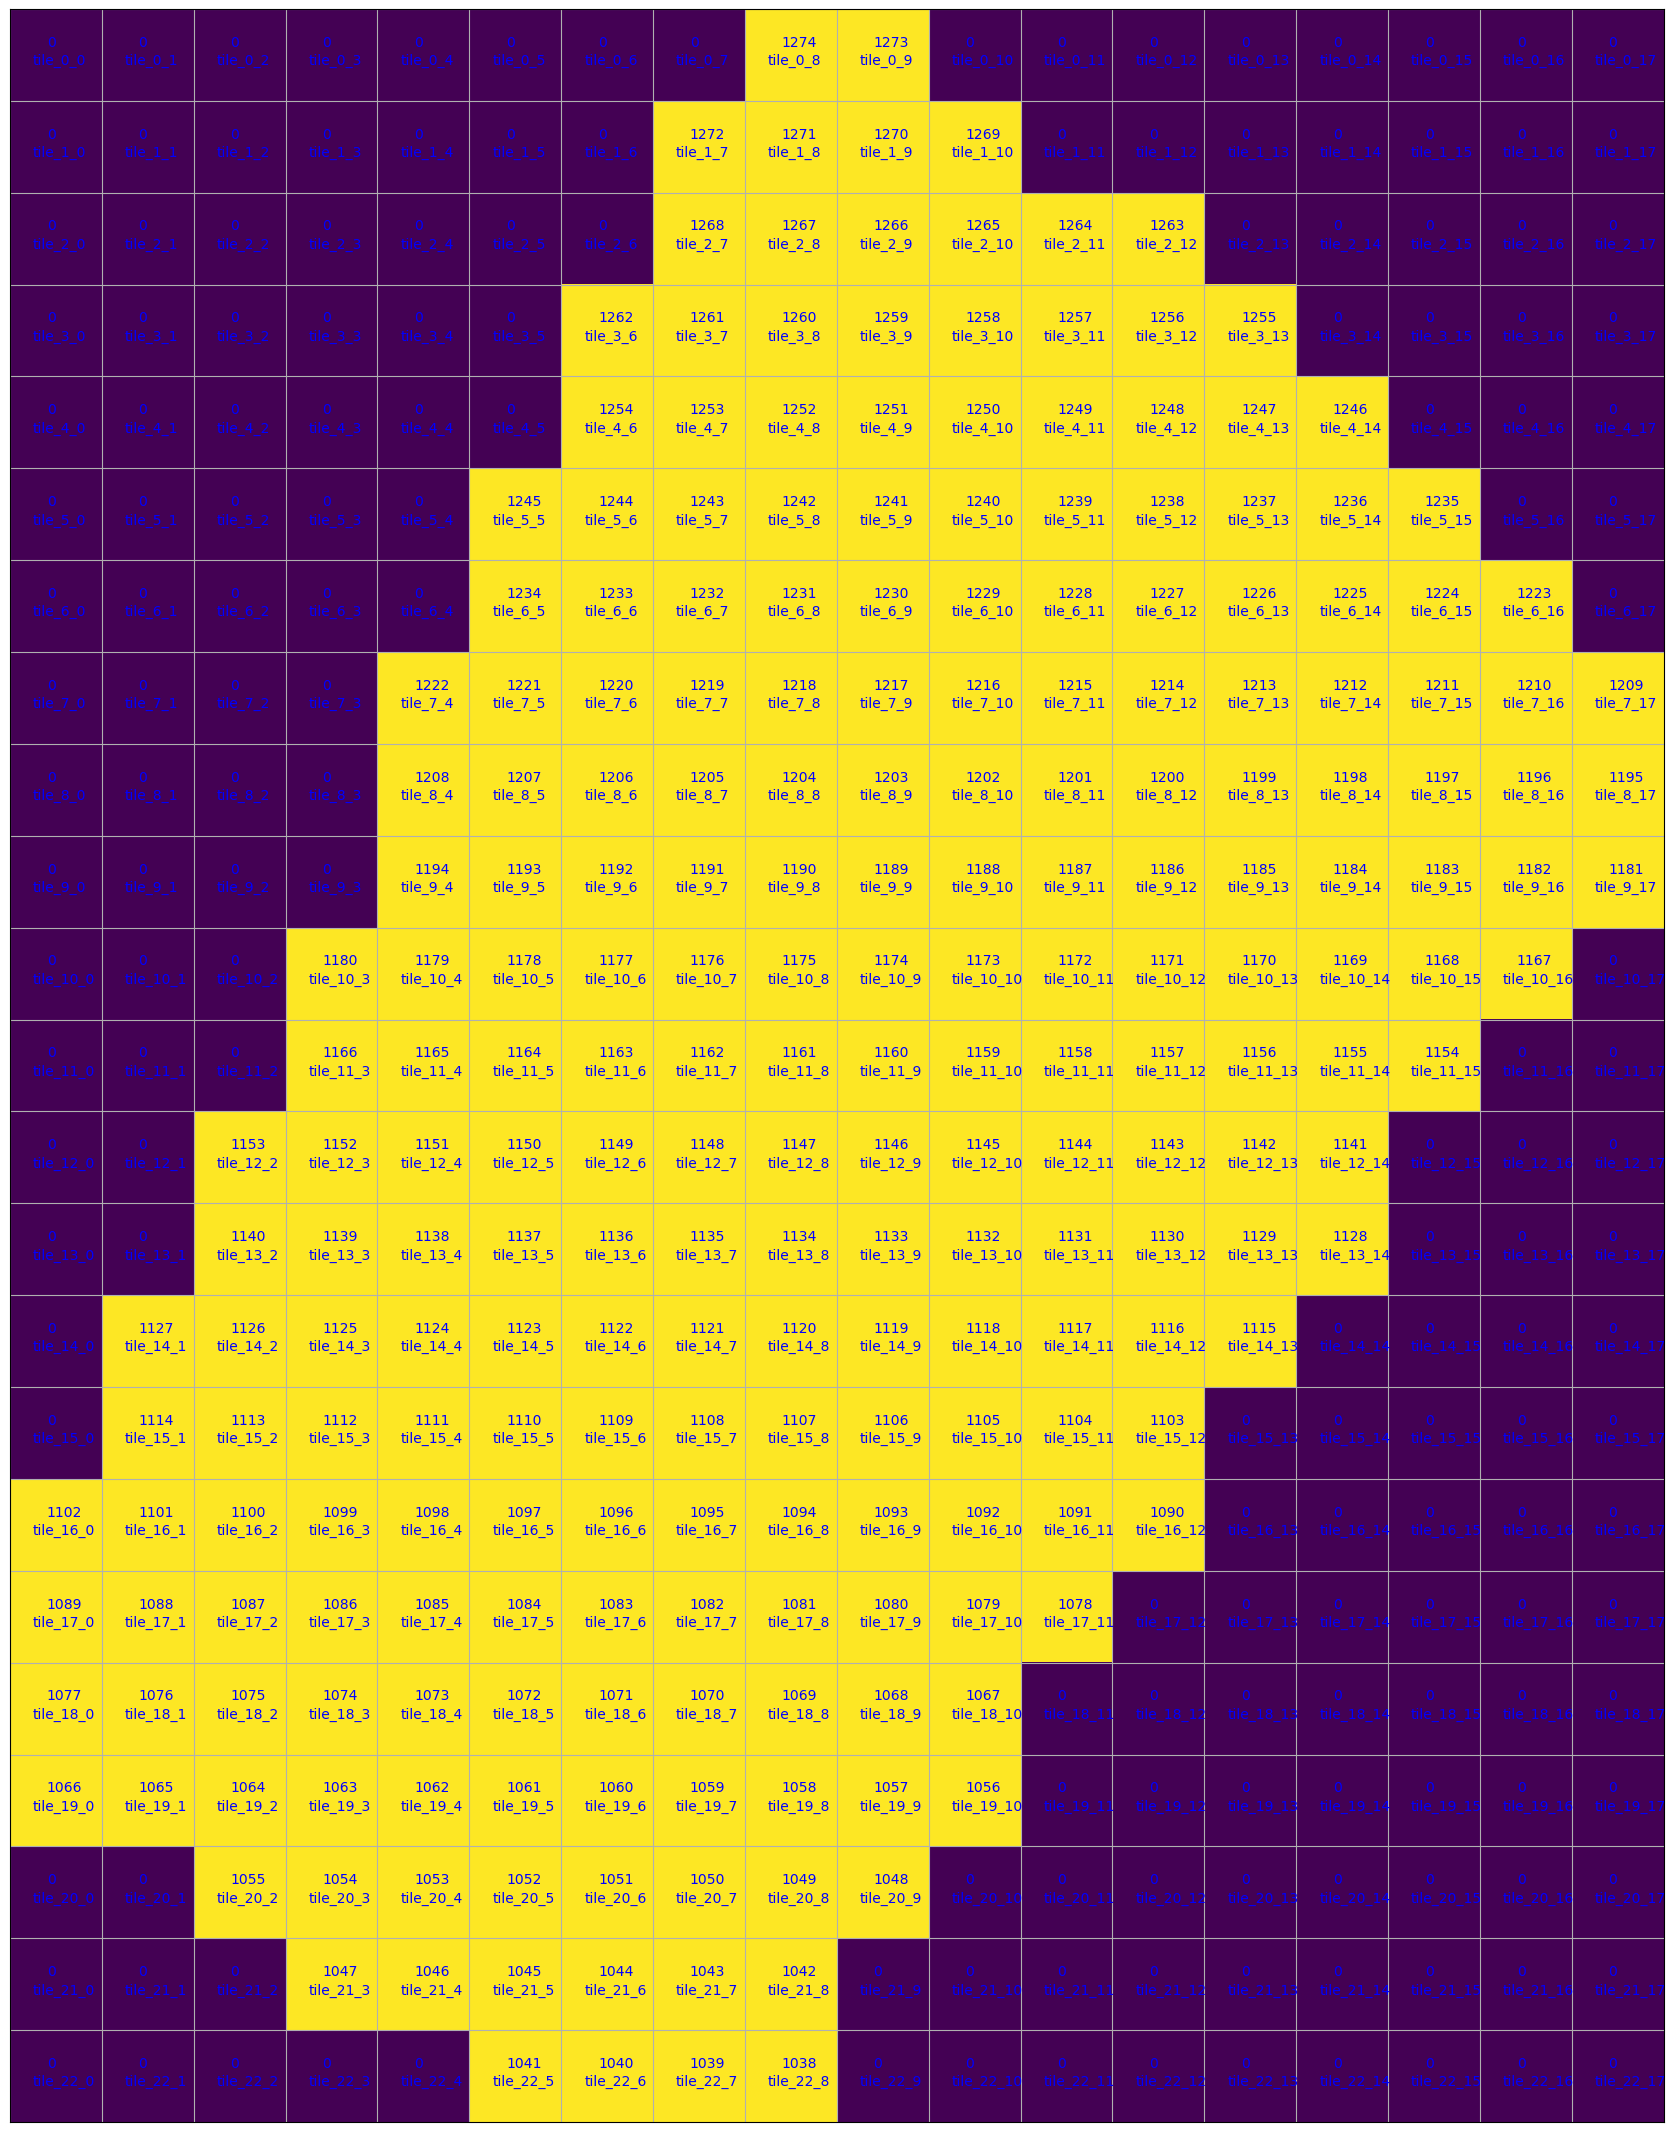

  0%|          | 0/414 [00:00<?, ?it/s]

sample6


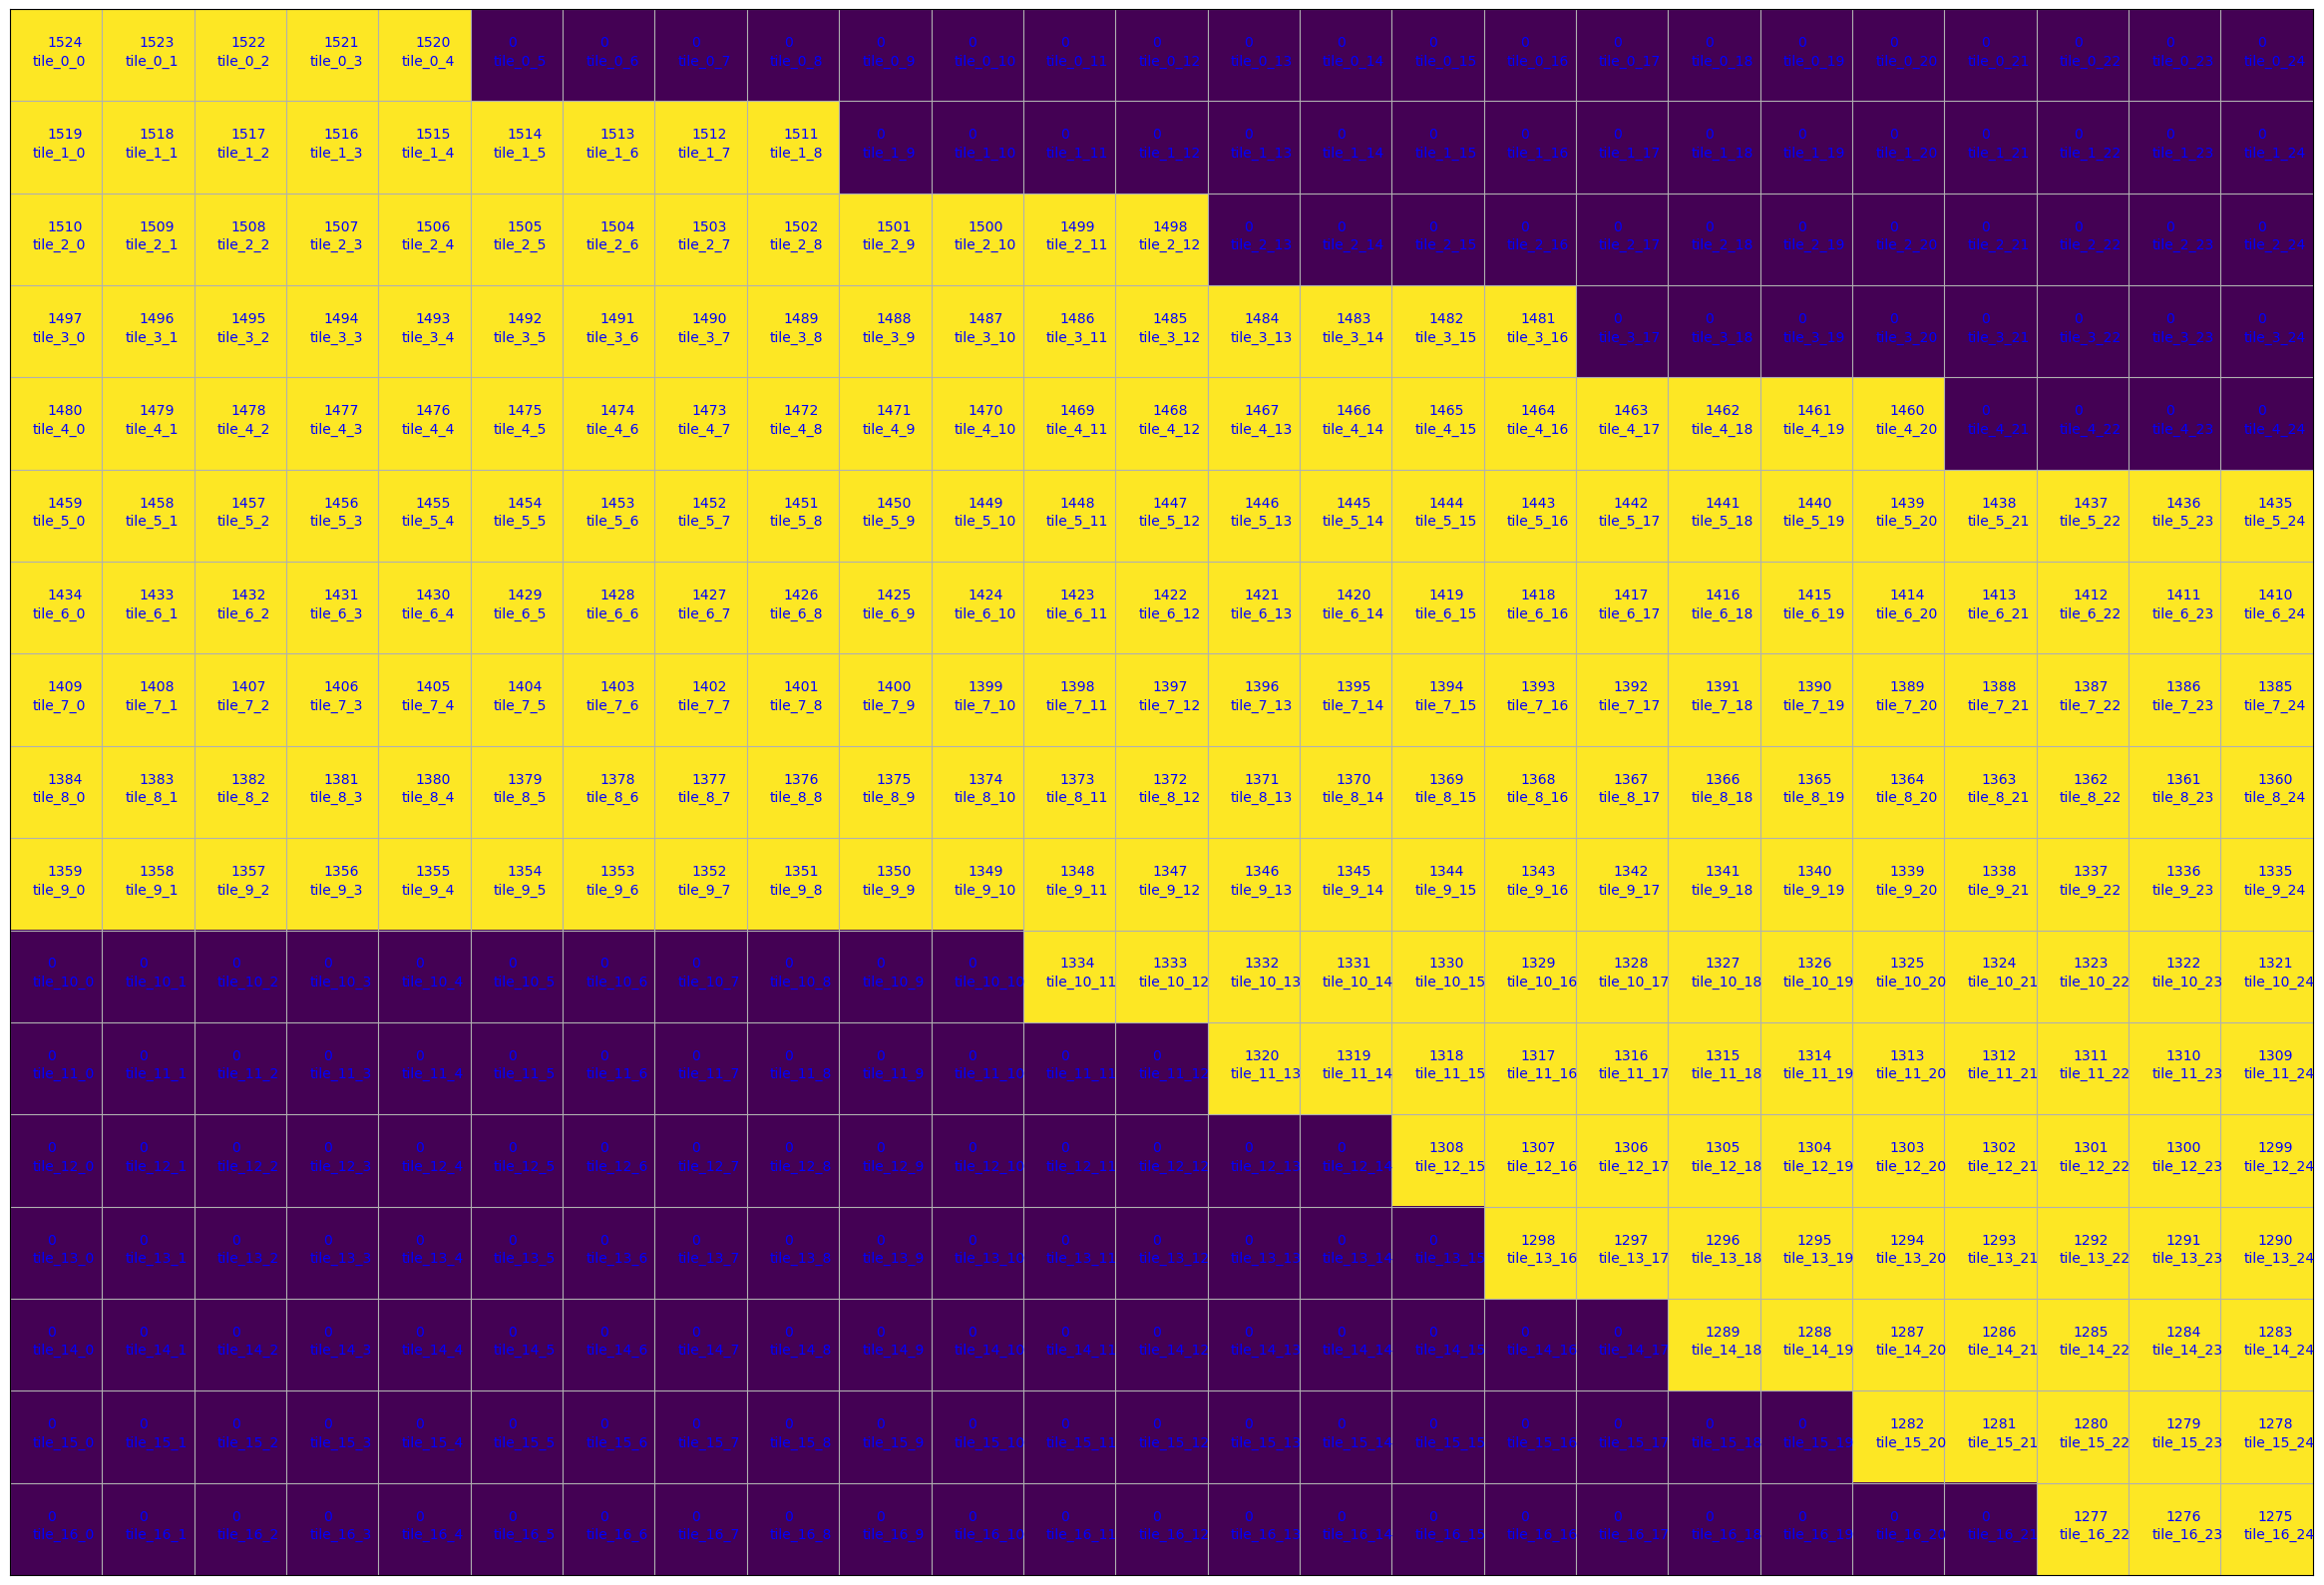

  0%|          | 0/425 [00:00<?, ?it/s]

In [6]:
from tqdm.notebook import tqdm
import shutil

base_path = '/home/unix/jiahao/wanglab/Data/Analyzed/2024-01-08-Jiakun-MouseSpleen64Gene/'
samples = [f.split(".")[0] for f in maf_files]

for i, current_sample in enumerate(tqdm(samples)):
    print(current_sample)
    current_output_path = os.path.join(base_path, f'images/fused/3D/{current_sample}')
    if not os.path.exists(current_output_path):
        os.mkdir(current_output_path)

    current_grid_fname = os.path.join(current_output_path, 'grid.tif')
    current_df = generate_stitching_order(os.path.join(input_path, f"{current_sample}.maf"), current_grid_fname)
    current_df.to_csv(os.path.join(current_output_path, 'grid.csv'))

    # input_ref_merged_path = os.path.join(base_path, 'images/ref_merged')
    input_dapi_merged_path = os.path.join(base_path, 'images/flamingo/DAPI')
    # input_flamingo_merged_path = os.path.join(base_path, 'images/flamingo/Flamingo')

    # current_ref_merged_output_path = os.path.join(current_output_path, 'ref_merged')
    # if not os.path.exists(current_ref_merged_output_path):
    #     os.mkdir(current_ref_merged_output_path)

    current_DAPI_output_path = os.path.join(current_output_path, 'DAPI')
    if not os.path.exists(current_DAPI_output_path):
        os.mkdir(current_DAPI_output_path)
        
    # current_Flamingo_output_path = os.path.join(current_output_path, 'Flamingo')
    # if not os.path.exists(current_Flamingo_output_path):
    #     os.mkdir(current_Flamingo_output_path)

    for j in tqdm(range(0, current_df.shape[0])):
        current_id = current_df.iloc[j, 2]
        current_grid = current_df.iloc[j, 3]
        current_position_id = f"Position{current_id:03}"

        # print(current_position_id, current_grid)
        if current_id == 0:
            src = os.path.join(base_path, 'images/fused/3D', 'blank.tif')
            # dest_merged = os.path.join(current_ref_merged_output_path, f"{current_grid}.tif")
            dest_dapi = os.path.join(current_DAPI_output_path, f"tile_{j}.tif")
            # dest_flamingo = os.path.join(current_Flamingo_output_path, f"{current_grid}.tif")

            # shutil.copyfile(src, dest_merged)
            shutil.copyfile(src, dest_dapi)
            # shutil.copyfile(src, dest_flamingo)

            # os.symlink(src, dest_merged)
            # os.symlink(src, dest_dapi)
        else:
            # src_merged = os.path.join(input_ref_merged_path, f"{current_position_id}.tif")
            src_dapi = os.path.join(input_dapi_merged_path, f"{current_position_id}.tif")
            # src_flamingo = os.path.join(input_flamingo_merged_path, f"{current_position_id}.tif")

            # dest_merged = os.path.join(current_ref_merged_output_path, f"{current_grid}.tif")
            dest_dapi = os.path.join(current_DAPI_output_path, f"tile_{j}.tif")
            # dest_flamingo = os.path.join(current_Flamingo_output_path, f"{current_grid}.tif")

            # shutil.copyfile(src_merged, dest_merged)
            shutil.copyfile(src_dapi, dest_dapi)
            # shutil.copyfile(src_flamingo, dest_flamingo)

            # os.symlink(src_merged, dest_merged)
            # os.symlink(src_dapi, dest_dapi)

  0%|          | 0/6 [00:00<?, ?it/s]

sample1


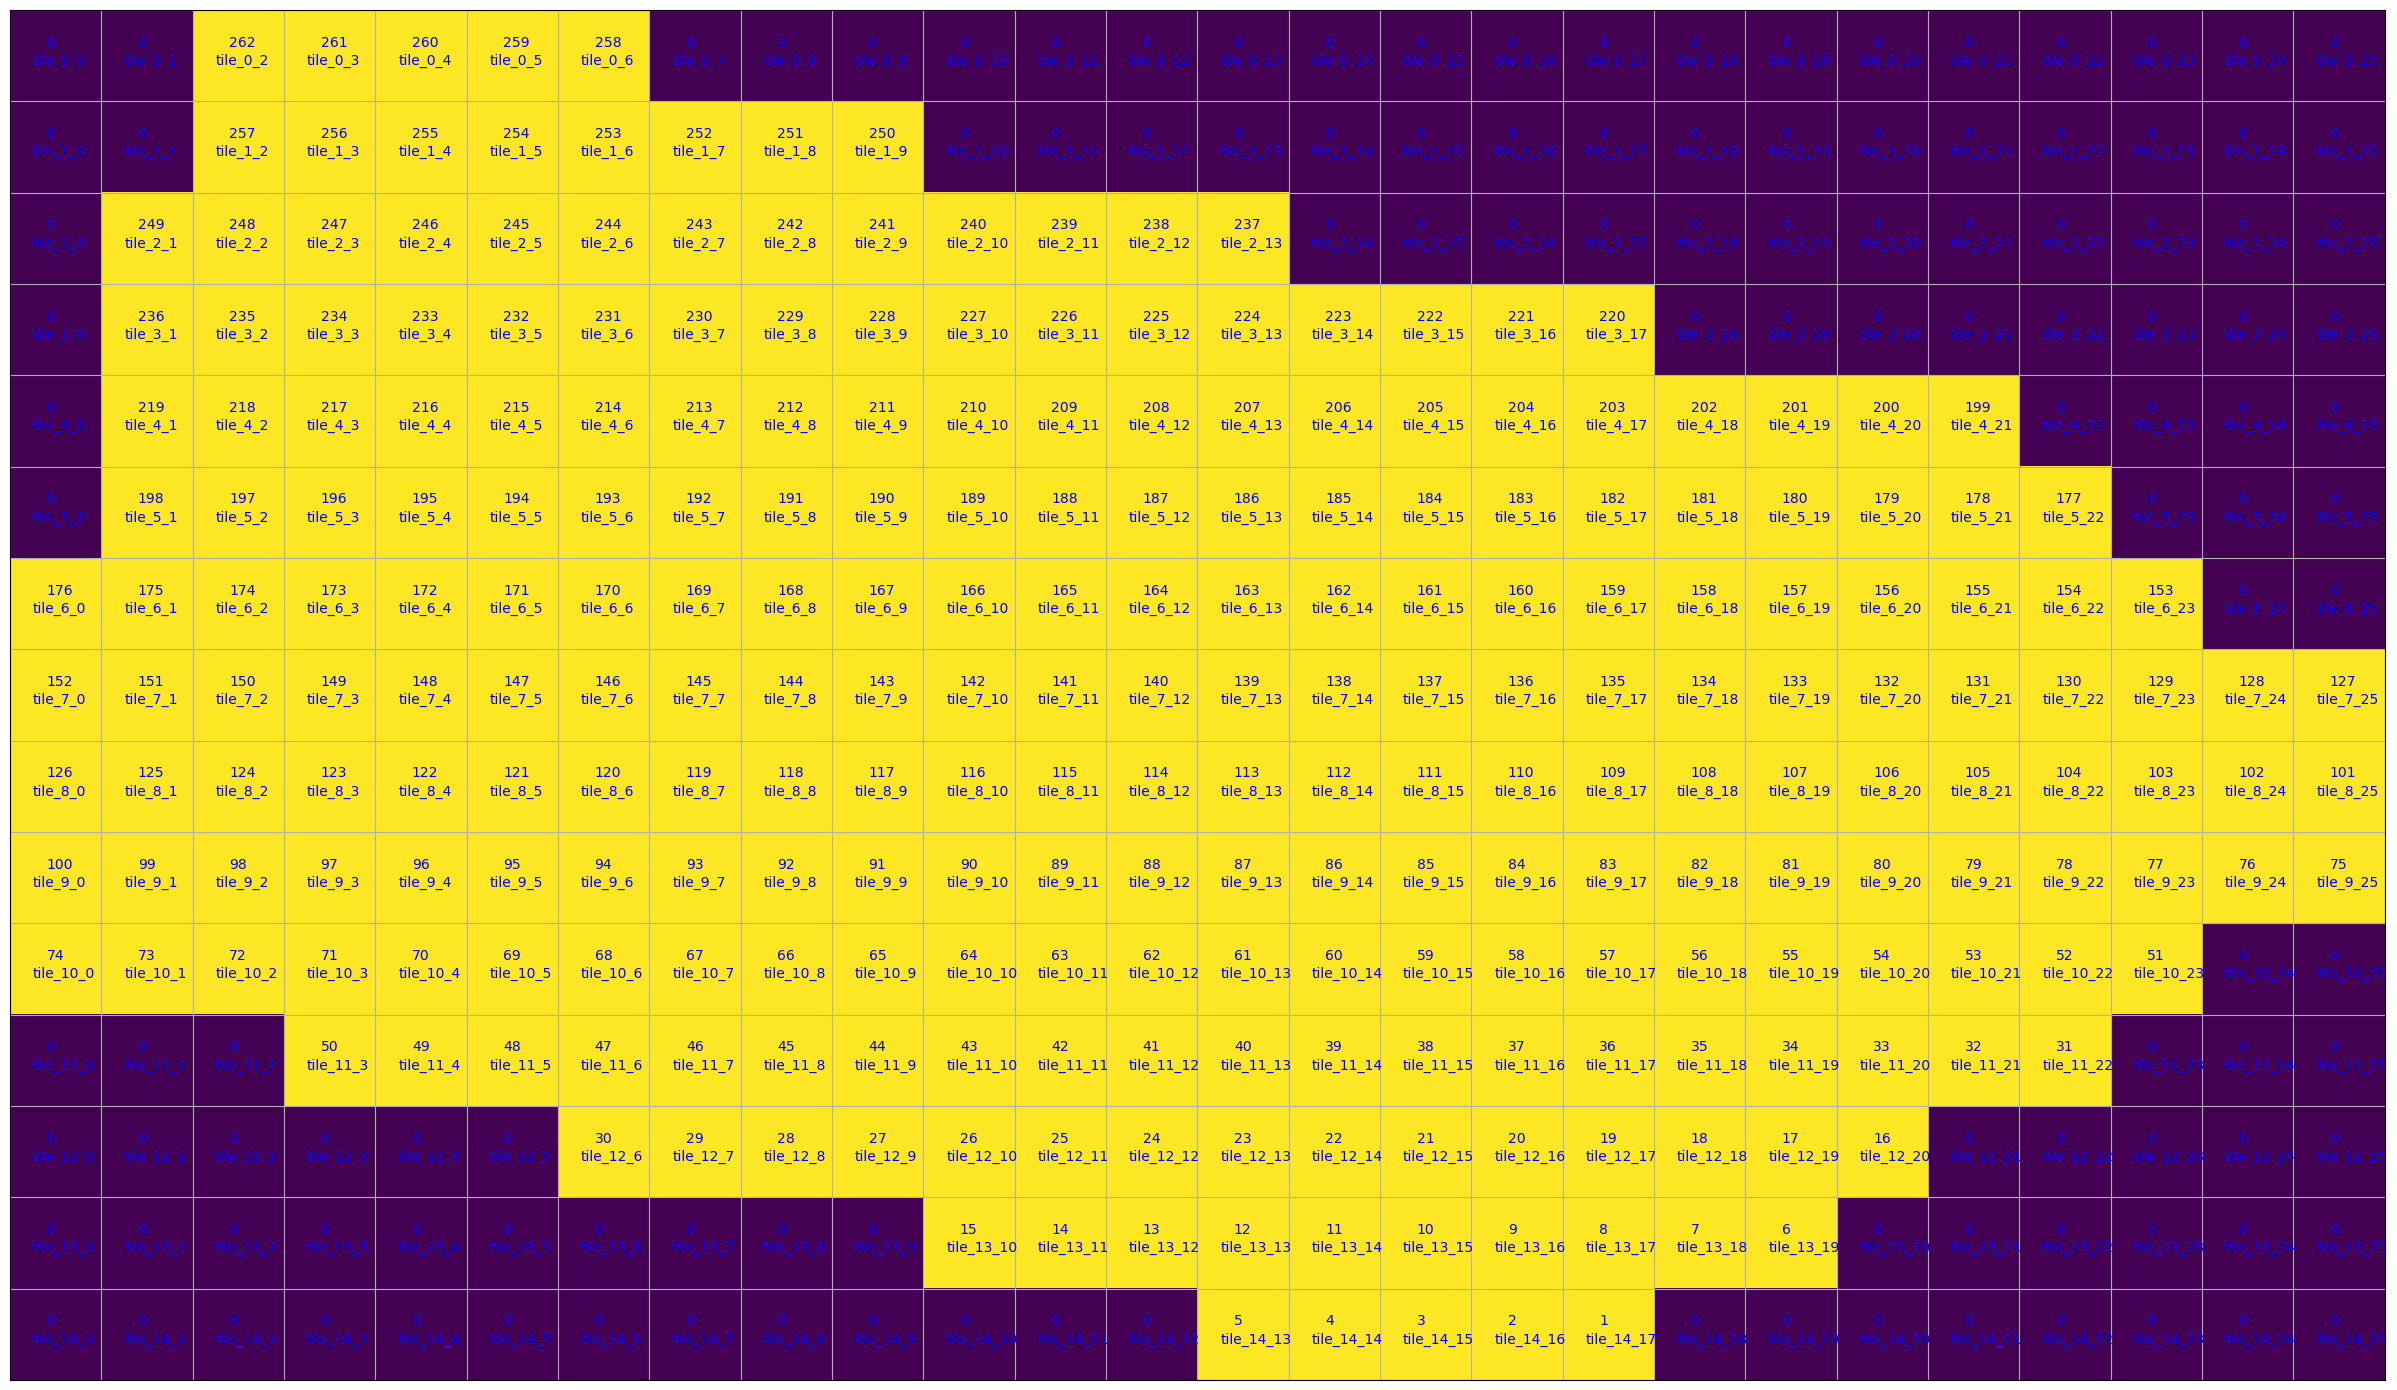

  0%|          | 0/390 [00:00<?, ?it/s]

sample2


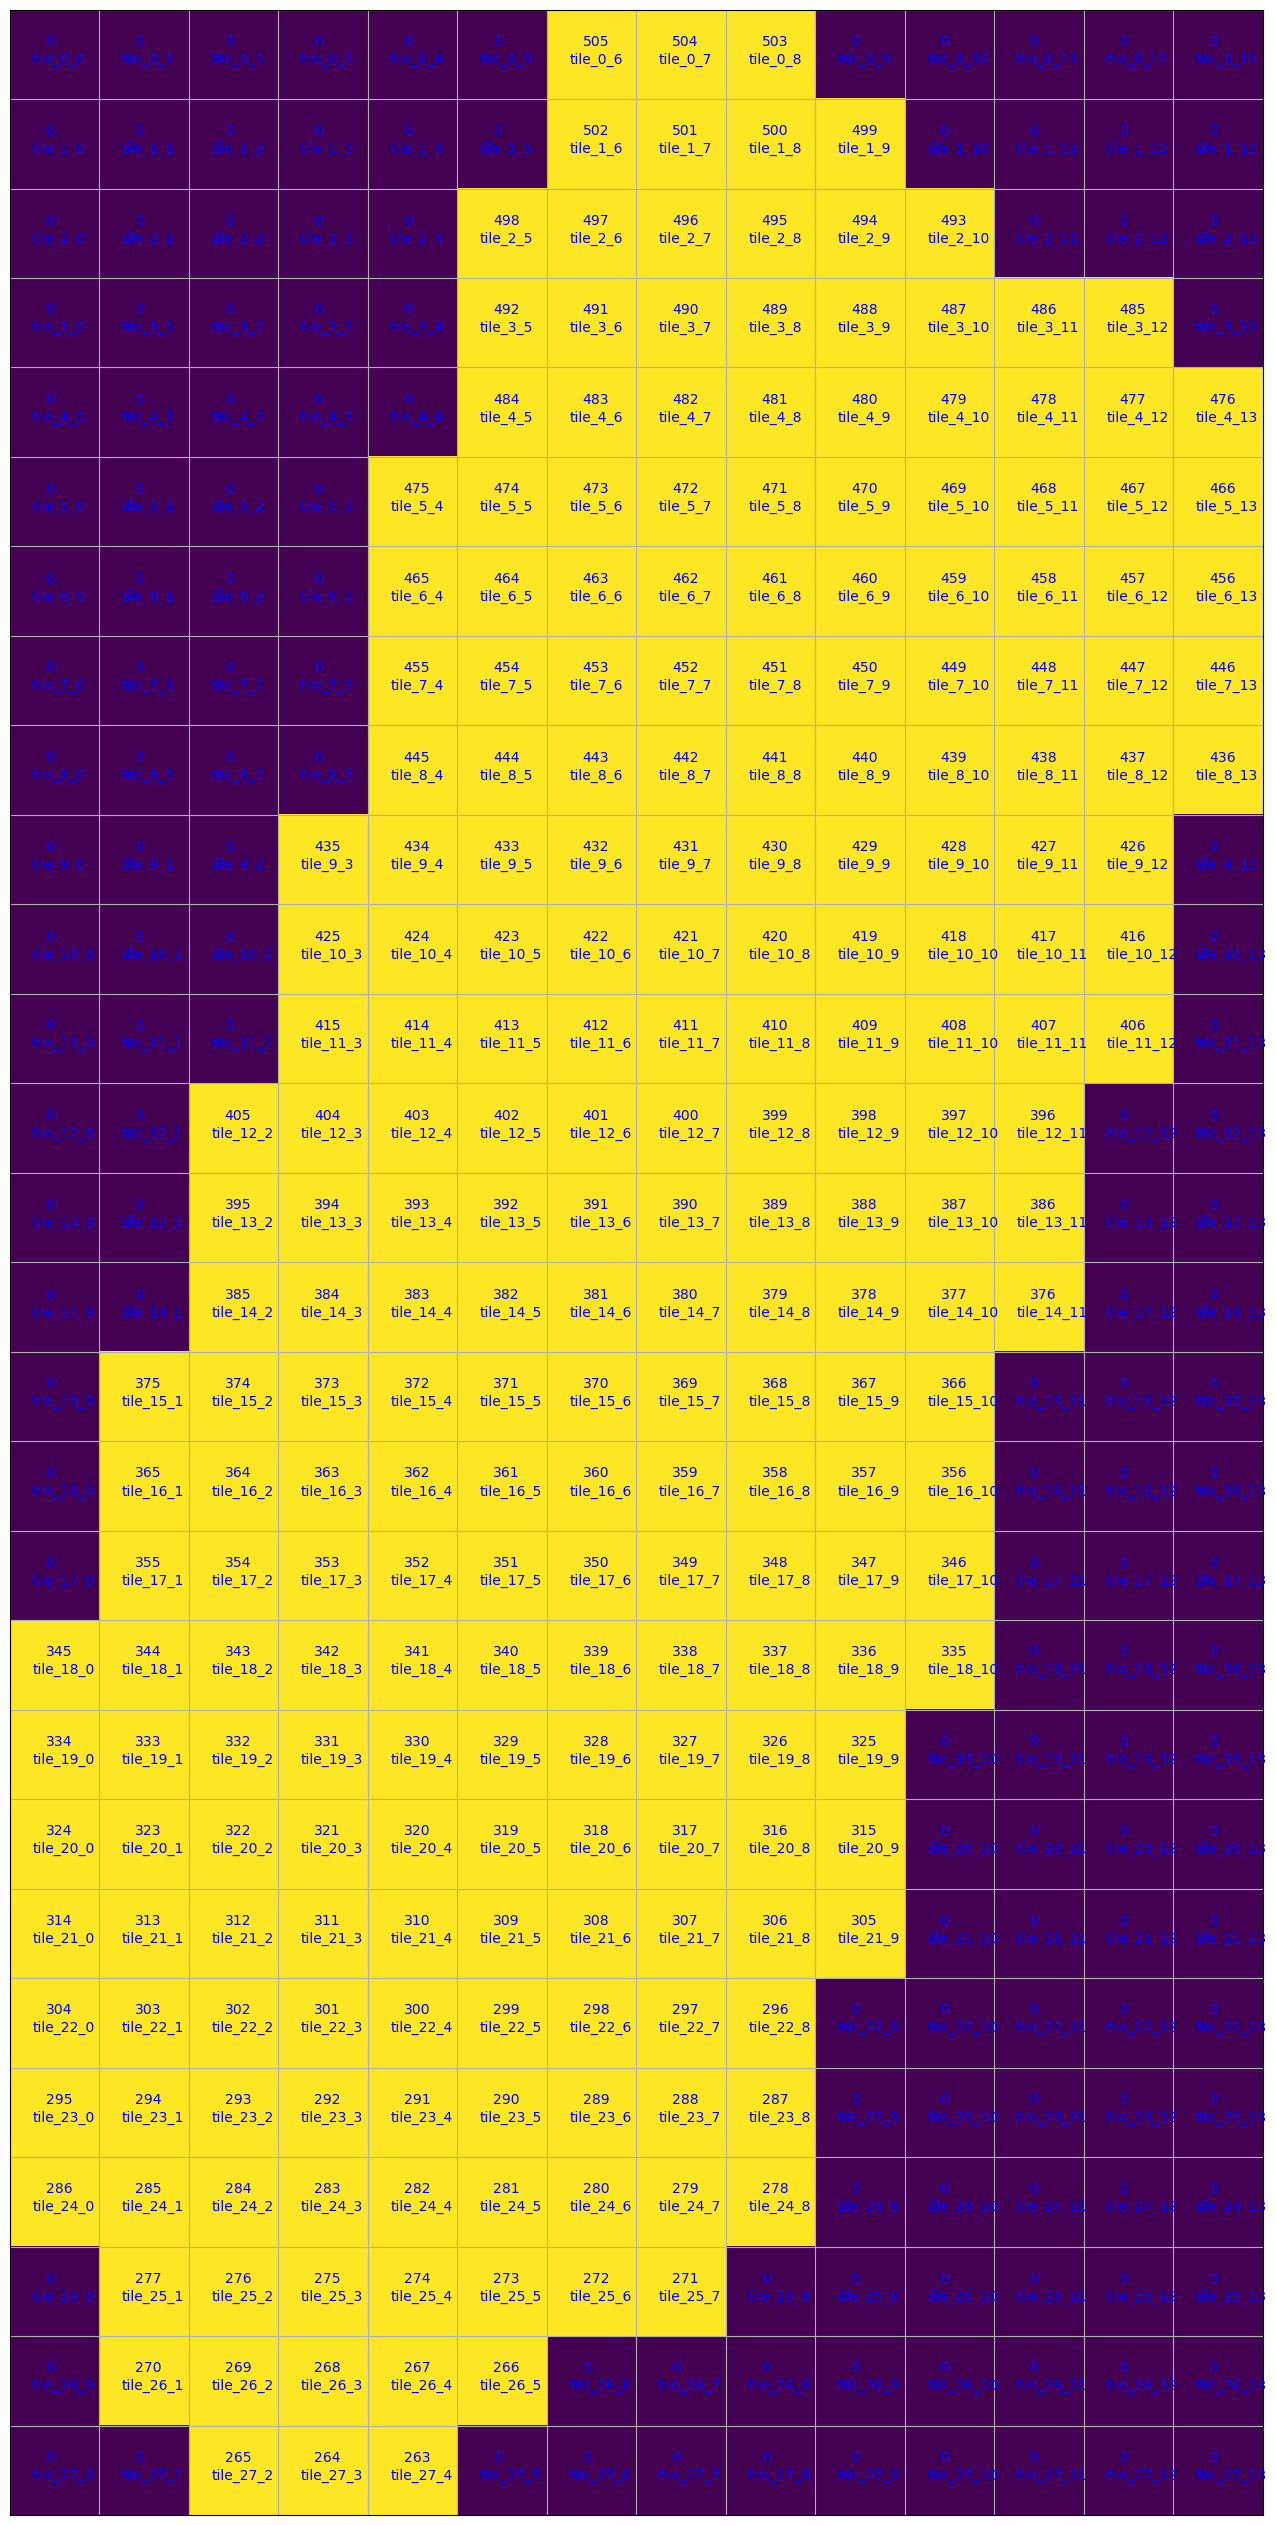

  0%|          | 0/392 [00:00<?, ?it/s]

sample3


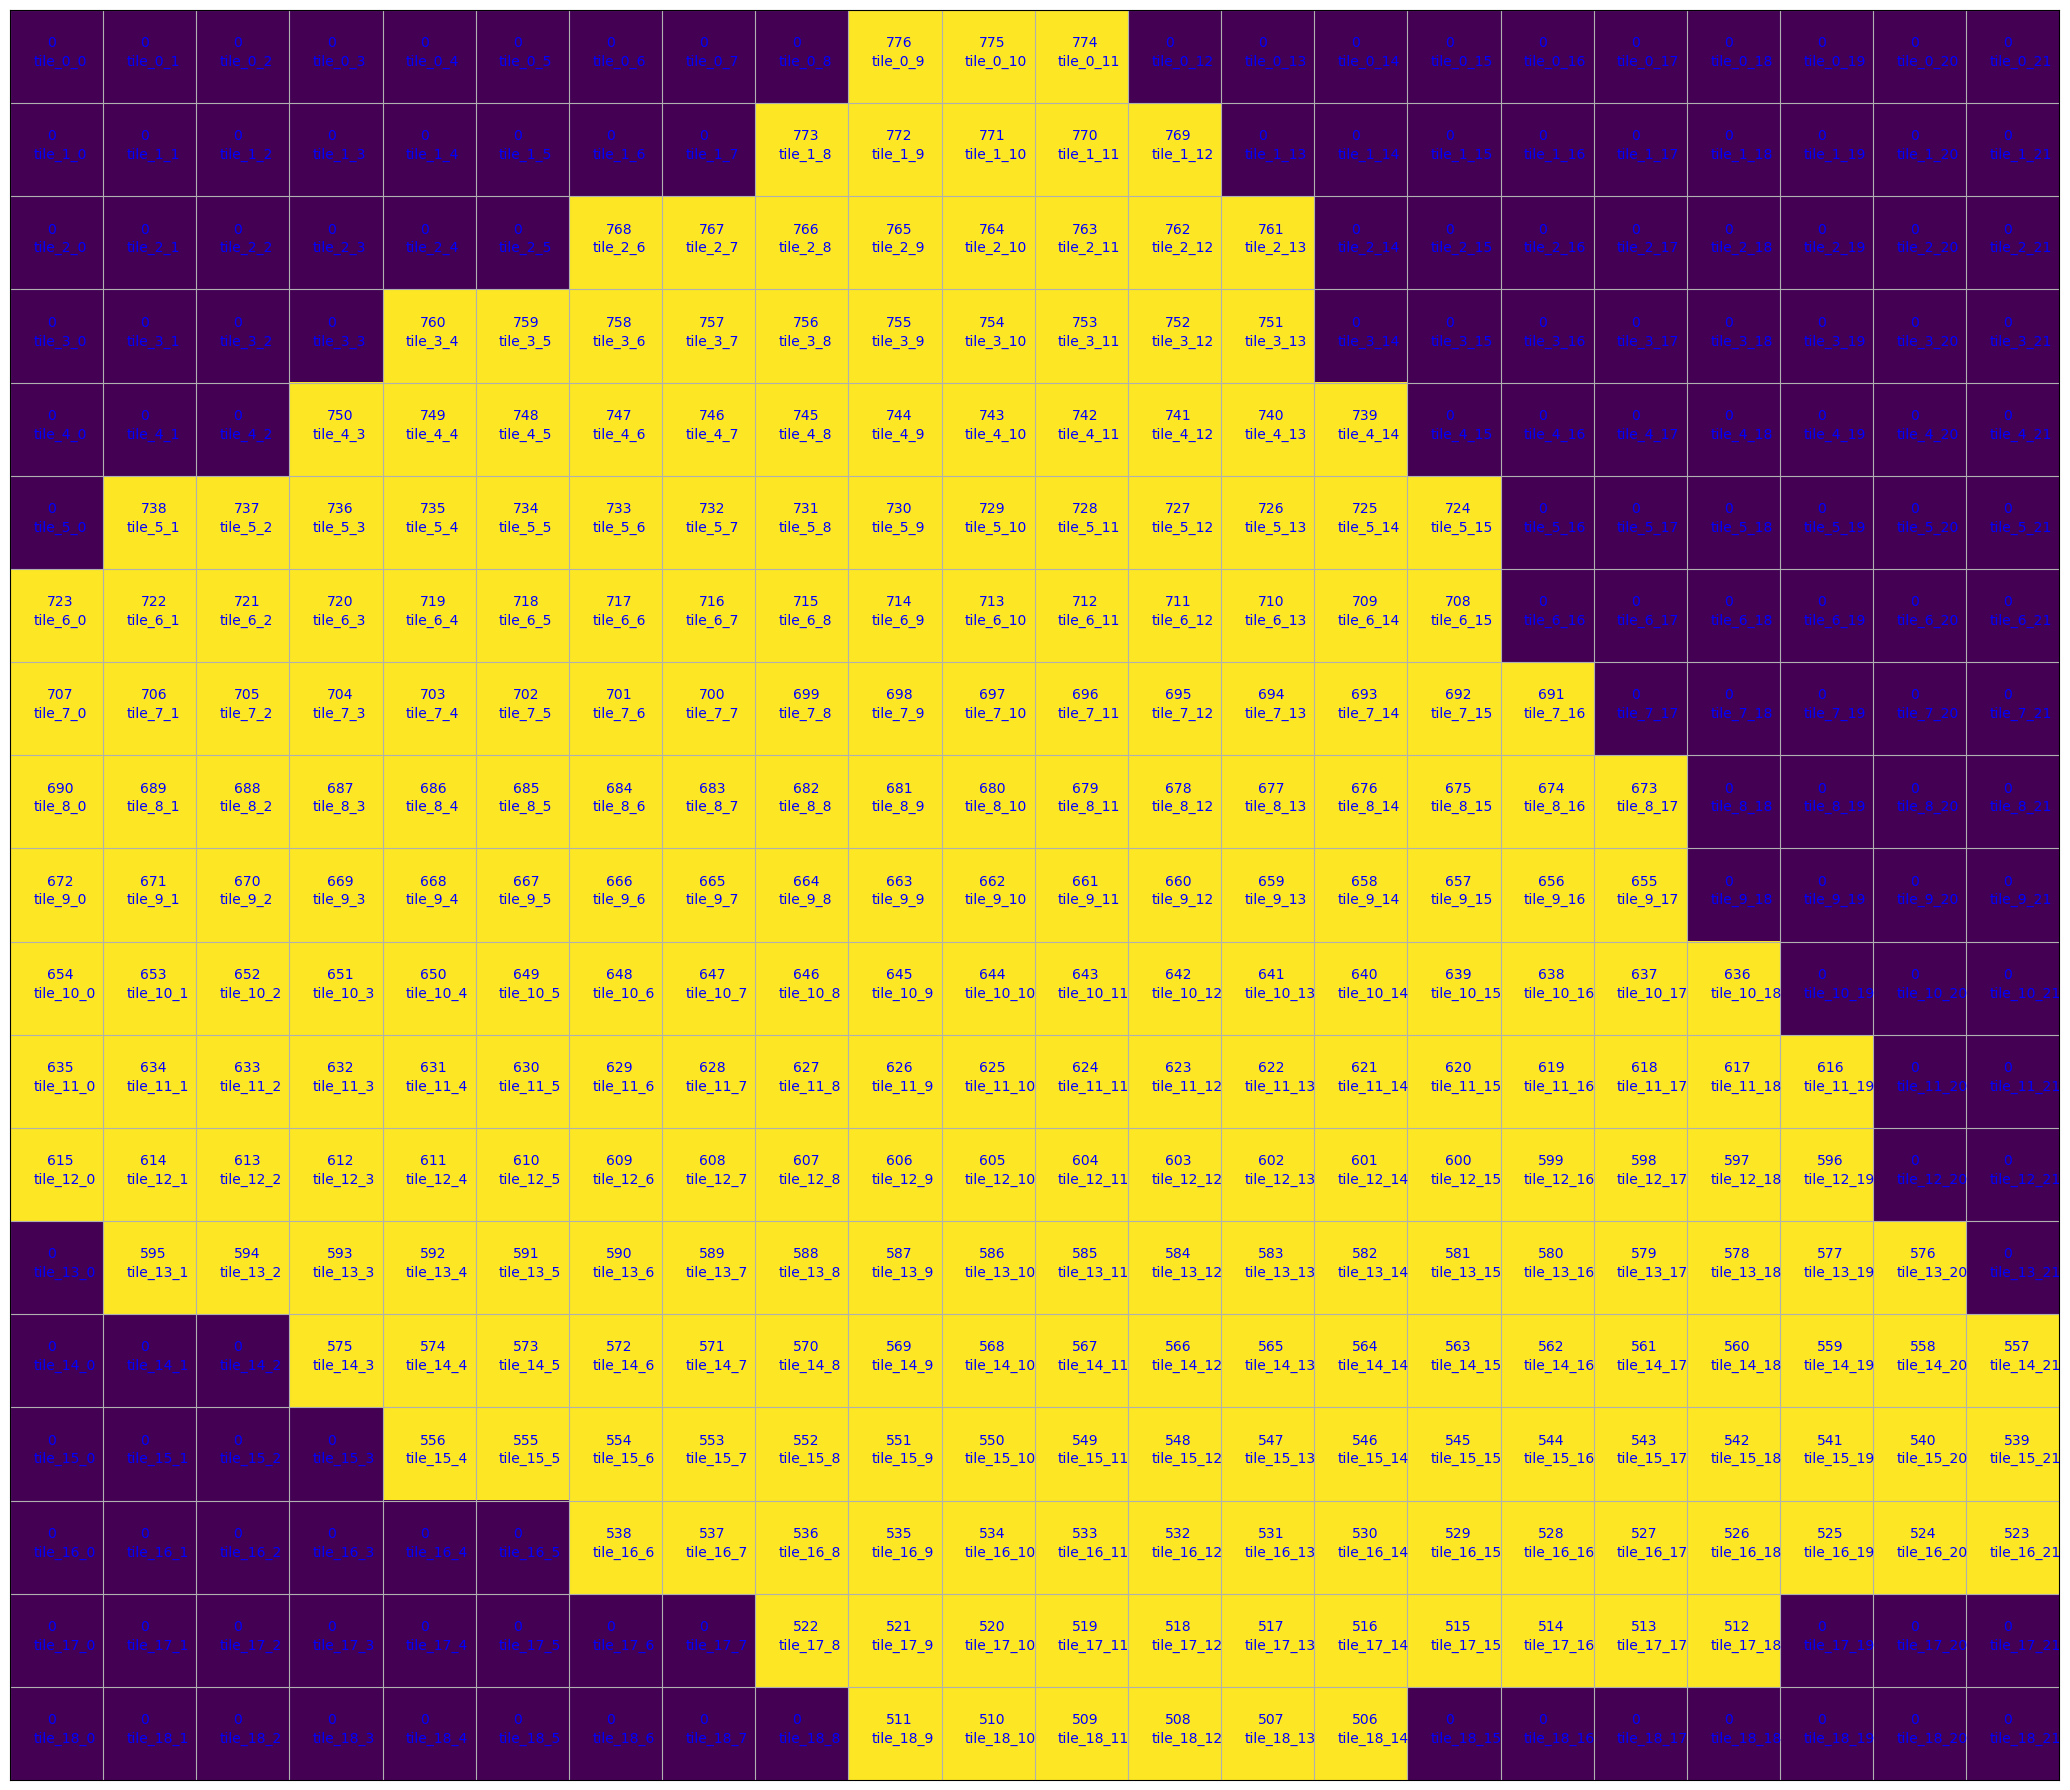

  0%|          | 0/418 [00:00<?, ?it/s]

sample4


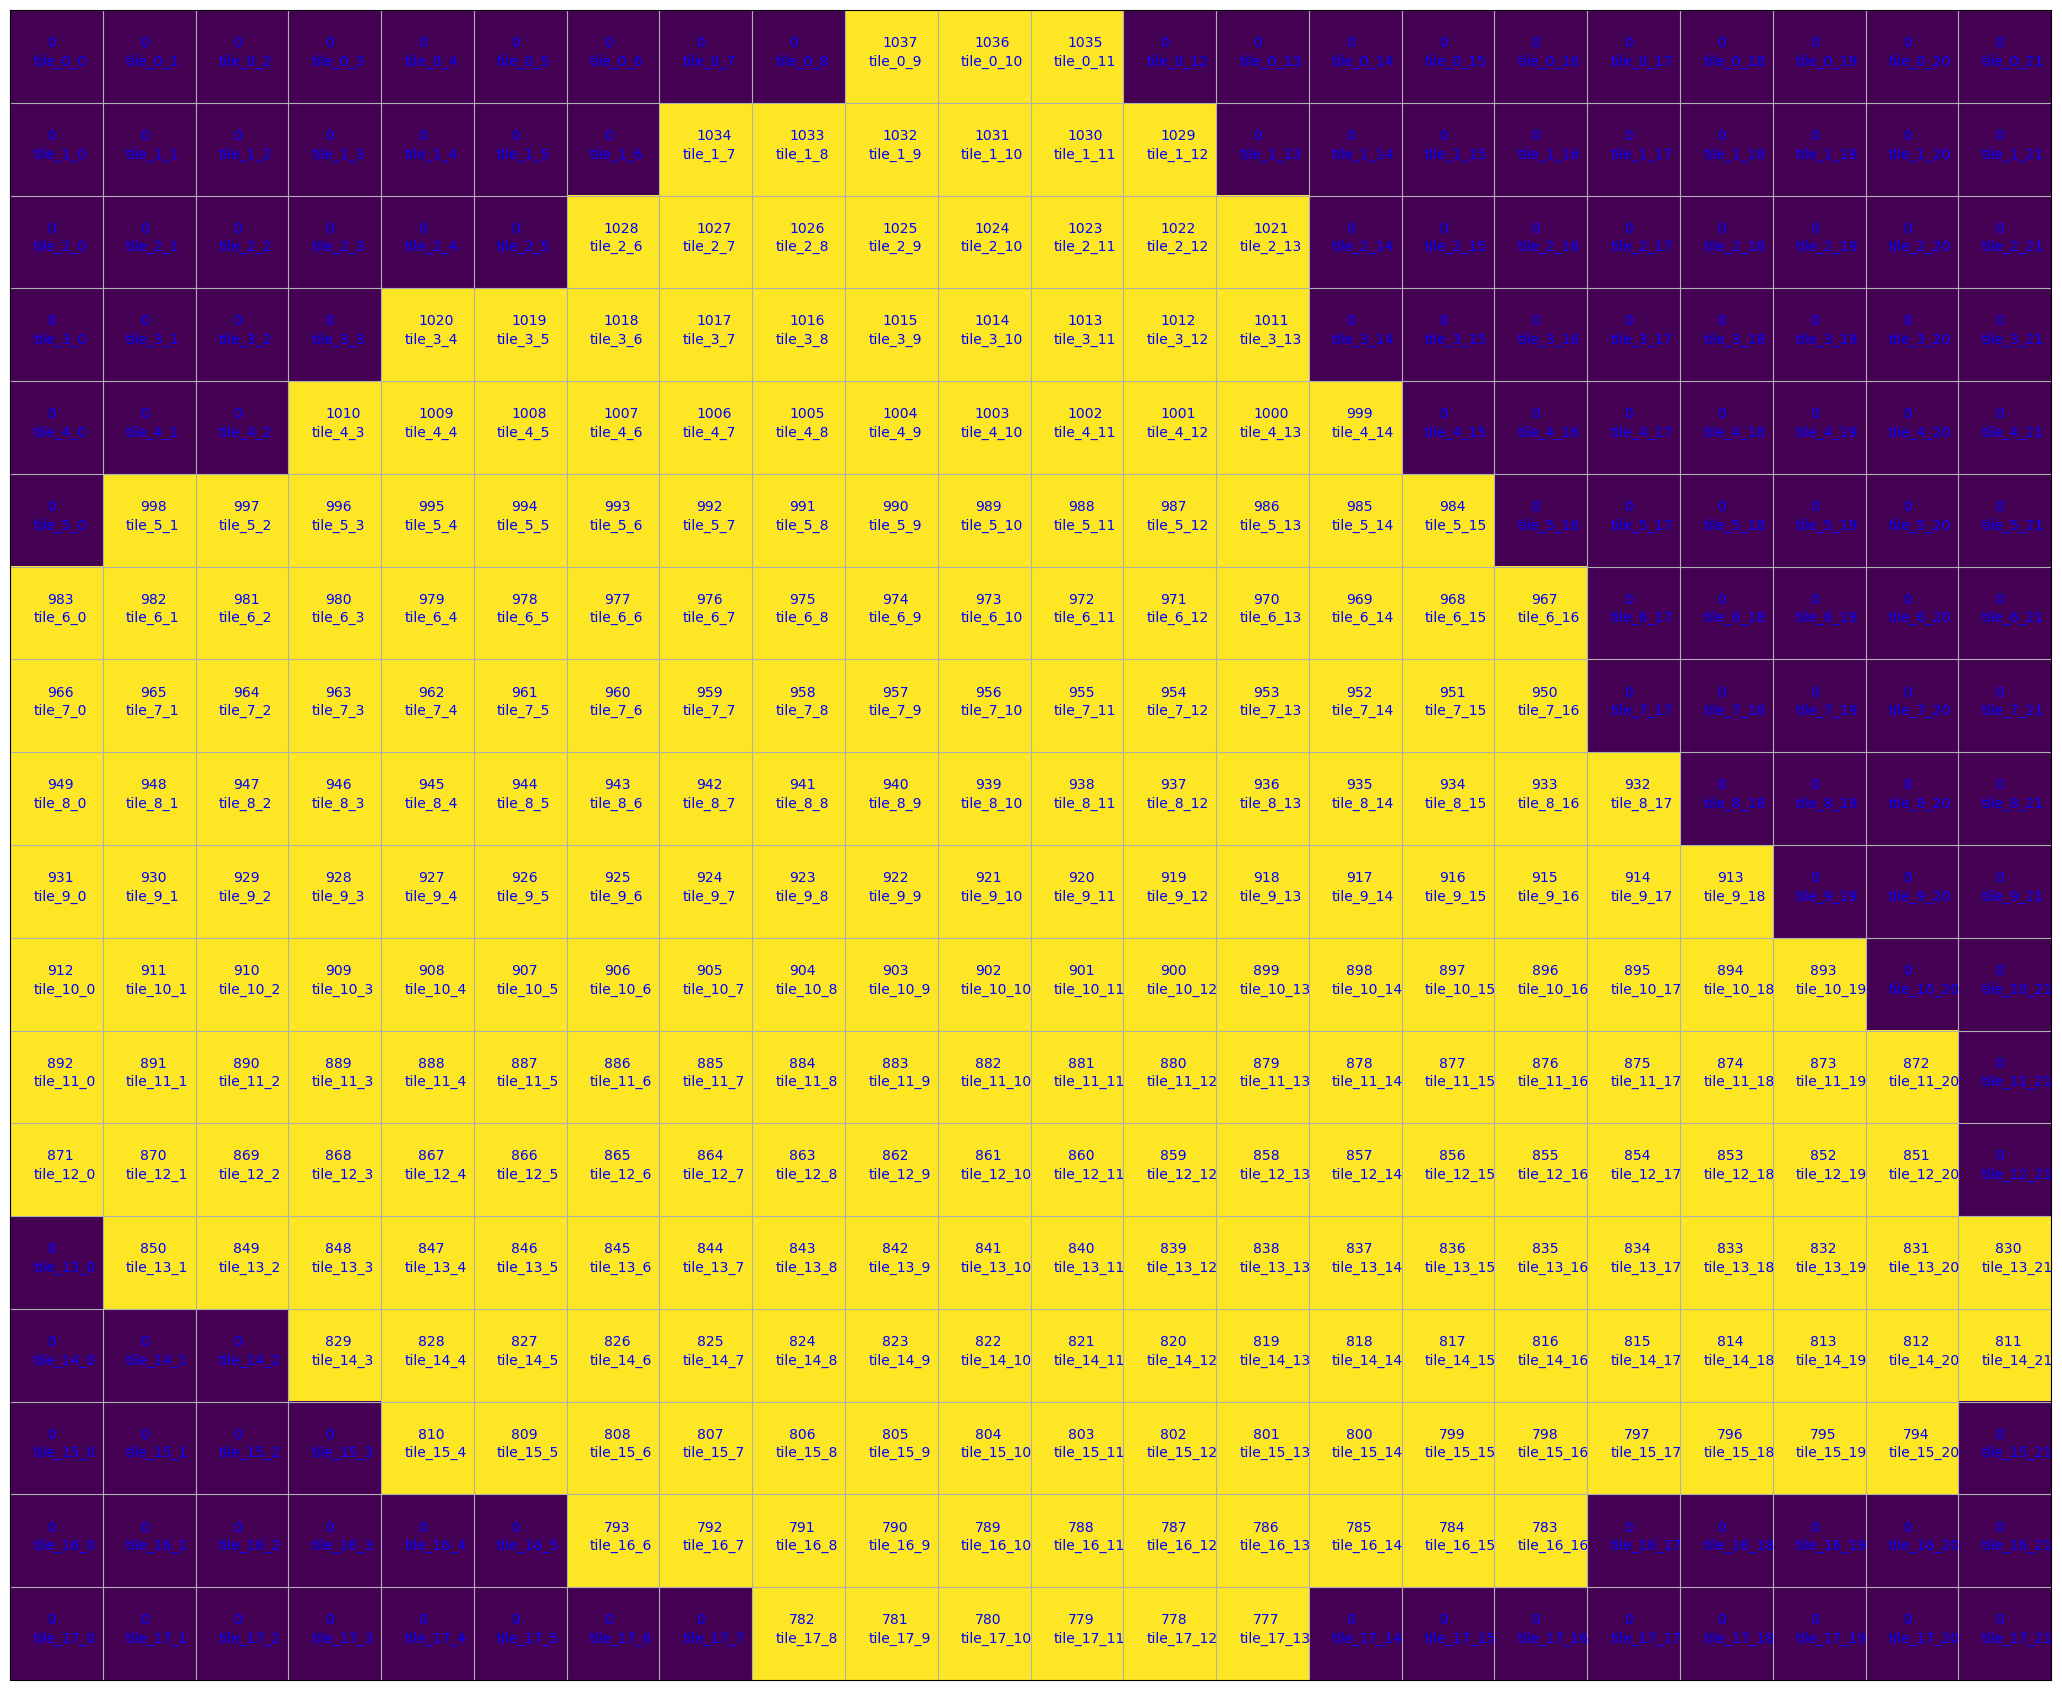

  0%|          | 0/396 [00:00<?, ?it/s]

sample5


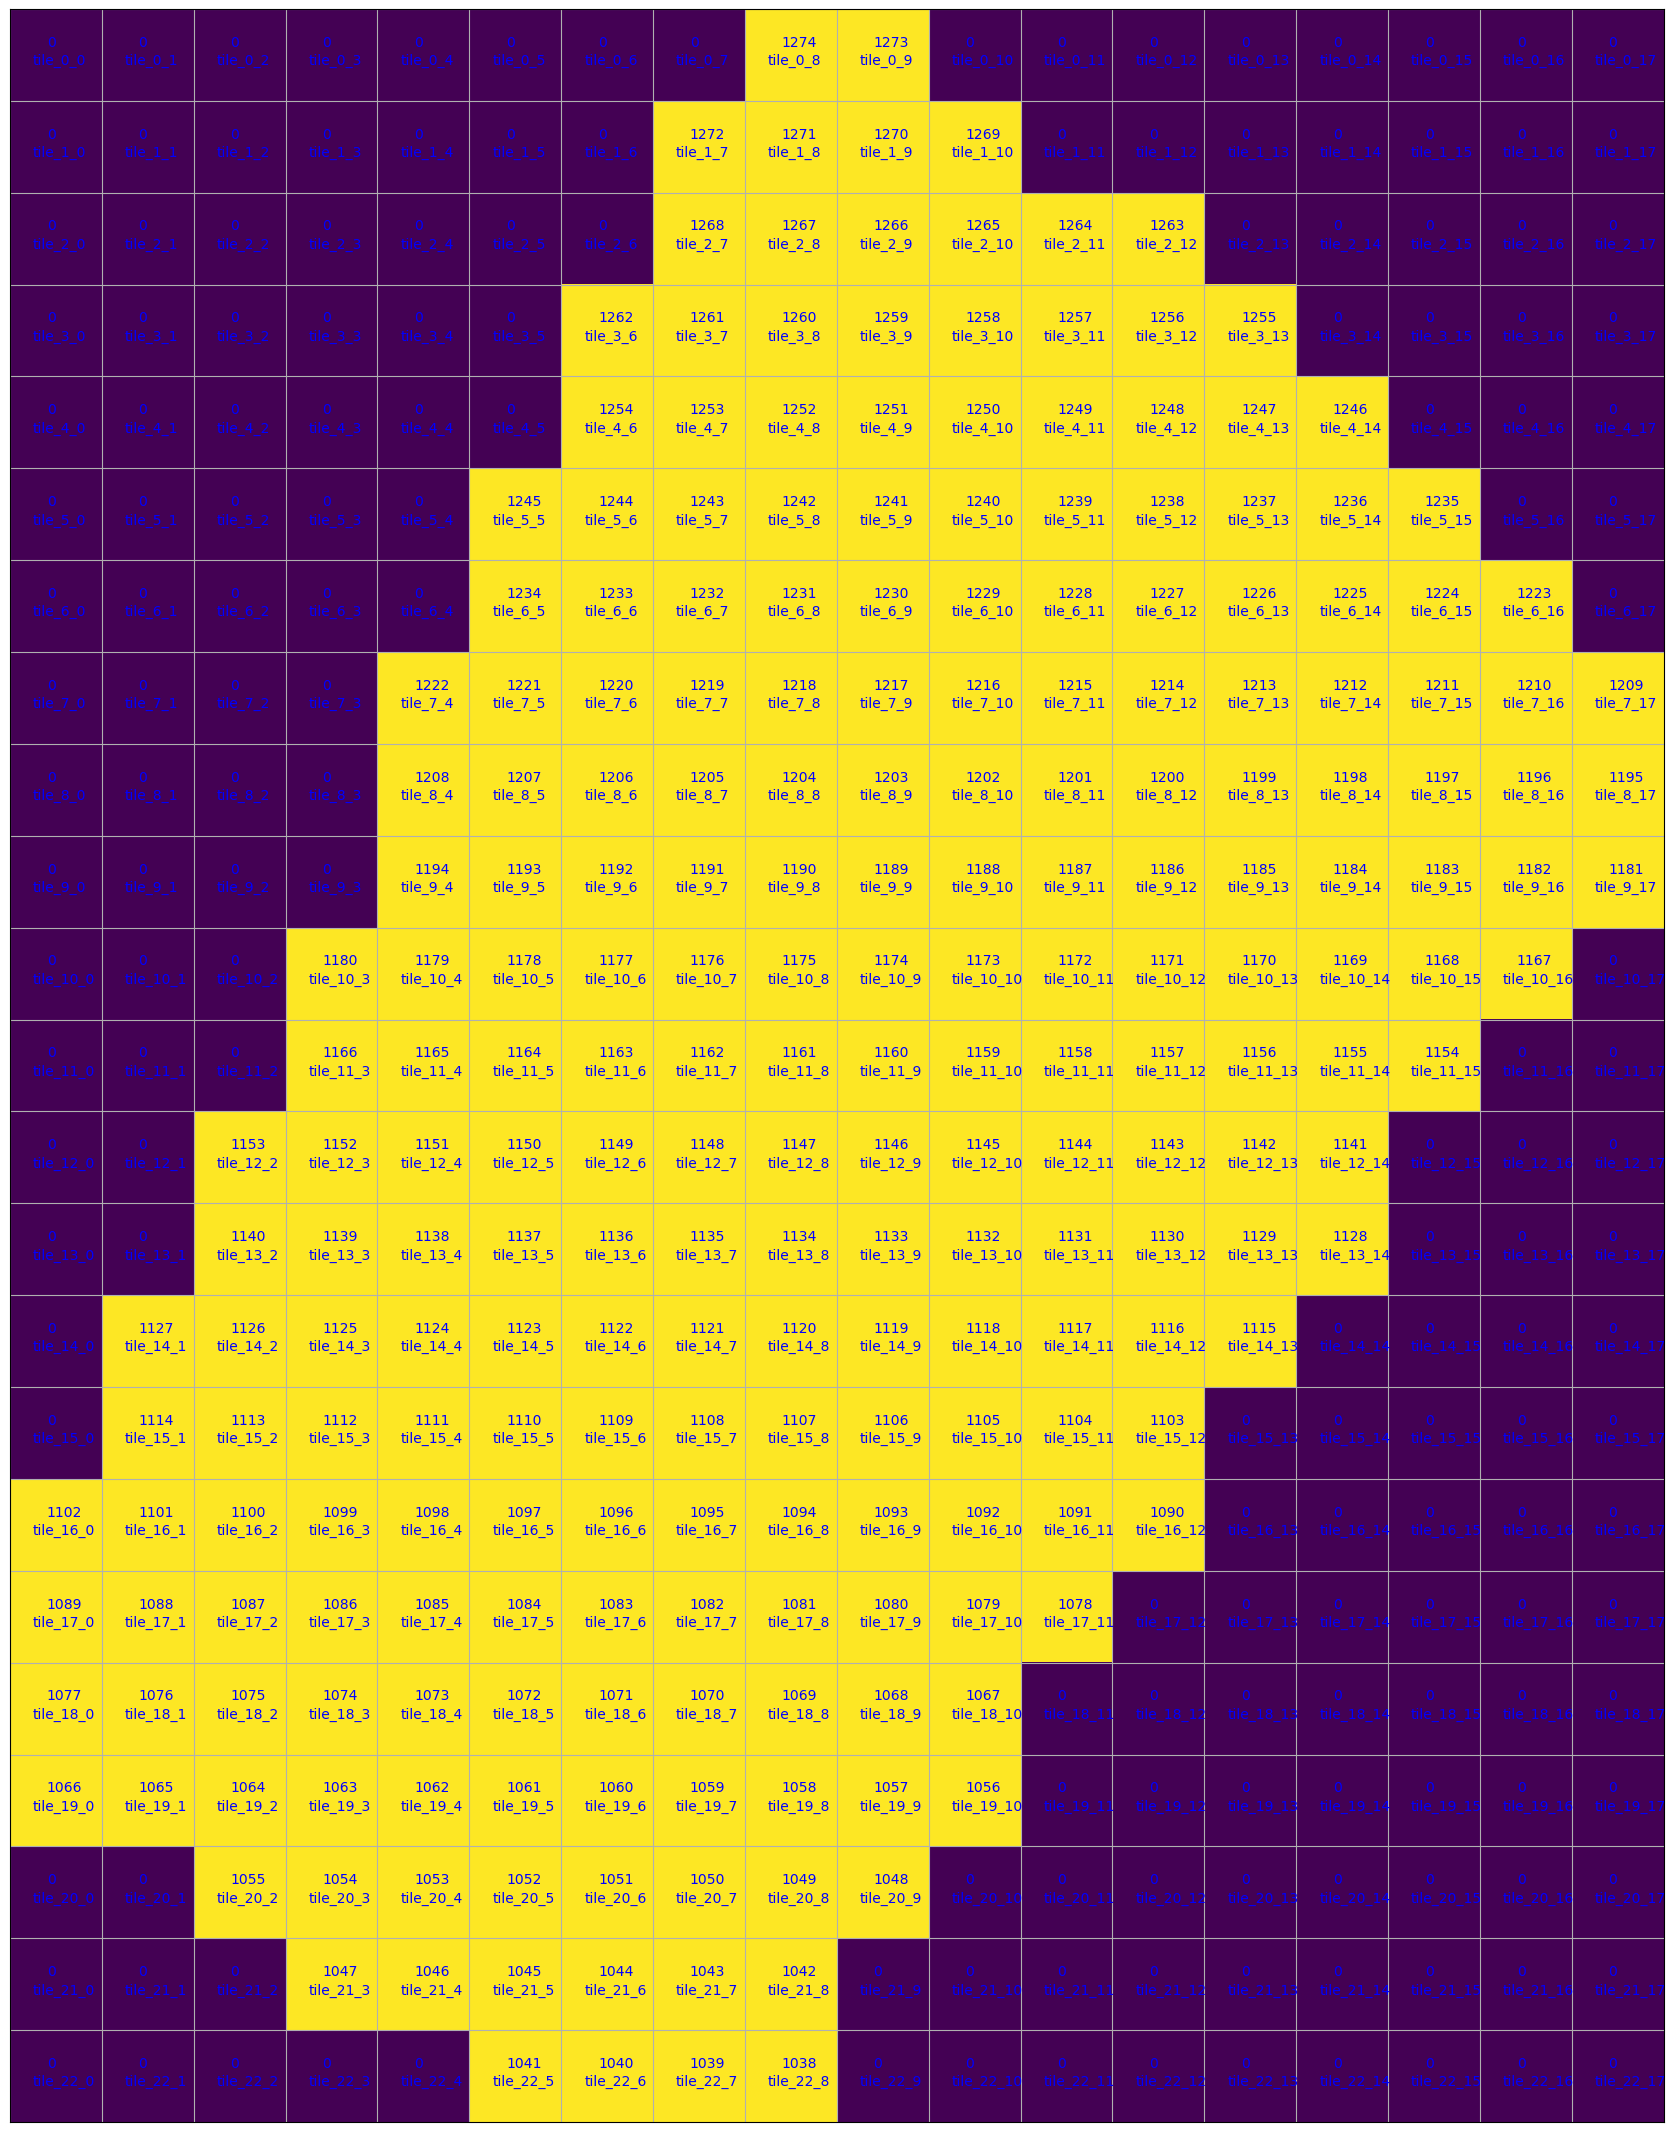

  0%|          | 0/414 [00:00<?, ?it/s]

sample6


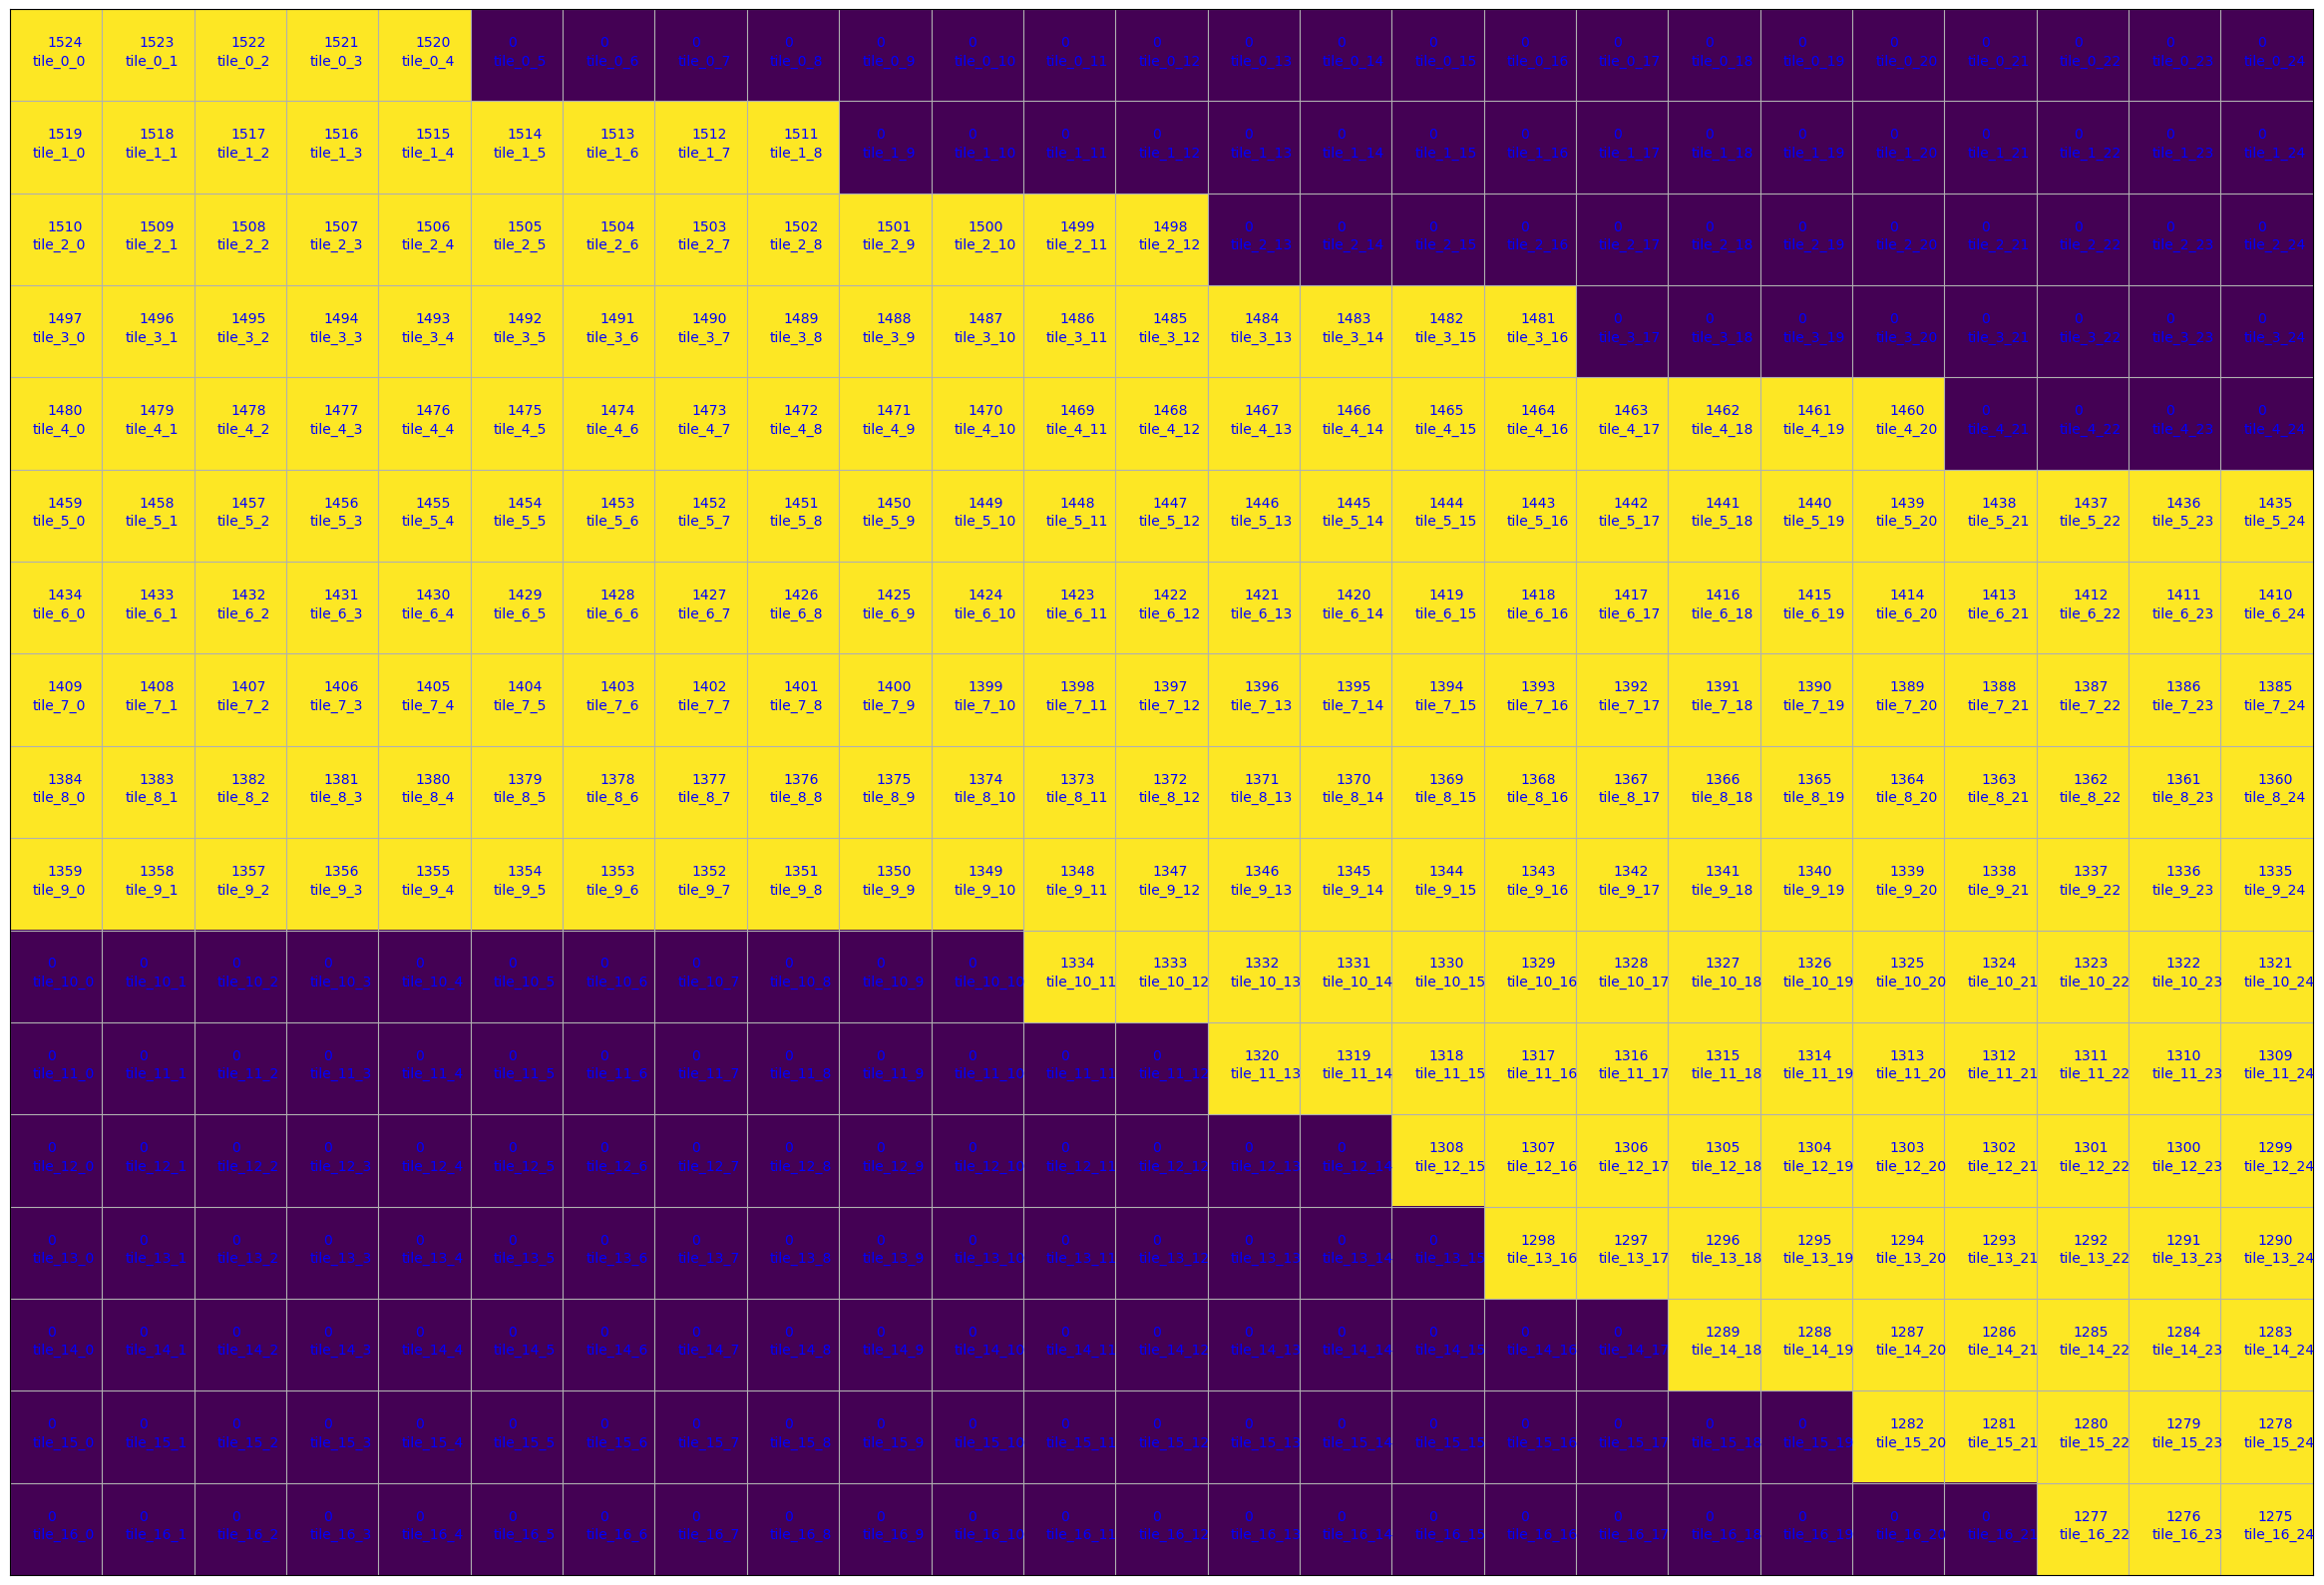

  0%|          | 0/425 [00:00<?, ?it/s]

In [18]:
from tqdm.notebook import tqdm
import shutil

base_path = '/home/unix/jiahao/wanglab/Data/Analyzed/2024-01-08-Jiakun-MouseSpleen64Gene/'
samples = [f.split(".")[0] for f in maf_files]

for i, current_sample in enumerate(tqdm(samples)):
    print(current_sample)
    current_output_path = os.path.join(base_path, f'images/fused/2D/{current_sample}')
    if not os.path.exists(current_output_path):
        os.mkdir(current_output_path)

    current_grid_fname = os.path.join(current_output_path, 'grid.tif')
    current_df = generate_stitching_order(os.path.join(input_path, f"{current_sample}.maf"), current_grid_fname)
    current_df.to_csv(os.path.join(current_output_path, 'grid.csv'))

    input_ref_merged_path = os.path.join(base_path, 'images/ref_merged_MAX')
    input_dapi_merged_path = os.path.join(base_path, 'images/flamingo/DAPI_MAX')
    input_flamingo_merged_path = os.path.join(base_path, 'images/flamingo/Flamingo_MAX')

    current_ref_merged_output_path = os.path.join(current_output_path, 'ref_merged')
    if not os.path.exists(current_ref_merged_output_path):
        os.mkdir(current_ref_merged_output_path)

    current_DAPI_output_path = os.path.join(current_output_path, 'DAPI')
    if not os.path.exists(current_DAPI_output_path):
        os.mkdir(current_DAPI_output_path)
        
    current_Flamingo_output_path = os.path.join(current_output_path, 'Flamingo')
    if not os.path.exists(current_Flamingo_output_path):
        os.mkdir(current_Flamingo_output_path)

    for j in tqdm(range(0, current_df.shape[0])):
        current_id = current_df.iloc[j, 2]
        current_grid = current_df.iloc[j, 3]
        current_position_id = f"Position{current_id:03}"

        # print(current_position_id, current_grid)
        if current_id == 0:
            src = os.path.join(base_path, 'images/fused/2D', 'blank.tif')
            dest_merged = os.path.join(current_ref_merged_output_path, f"{current_grid}.tif")
            dest_dapi = os.path.join(current_DAPI_output_path, f"{current_grid}.tif")
            dest_flamingo = os.path.join(current_Flamingo_output_path, f"{current_grid}.tif")

            shutil.copyfile(src, dest_merged)
            shutil.copyfile(src, dest_dapi)
            shutil.copyfile(src, dest_flamingo)

            # os.symlink(src, dest_merged)
            # os.symlink(src, dest_dapi)
        else:
            src_merged = os.path.join(input_ref_merged_path, f"{current_position_id}.tif")
            src_dapi = os.path.join(input_dapi_merged_path, f"{current_position_id}.tif")
            src_flamingo = os.path.join(input_flamingo_merged_path, f"{current_position_id}.tif")

            dest_merged = os.path.join(current_ref_merged_output_path, f"{current_grid}.tif")
            dest_dapi = os.path.join(current_DAPI_output_path, f"{current_grid}.tif")
            dest_flamingo = os.path.join(current_Flamingo_output_path, f"{current_grid}.tif")

            shutil.copyfile(src_merged, dest_merged)
            shutil.copyfile(src_dapi, dest_dapi)
            shutil.copyfile(src_flamingo, dest_flamingo)

            # os.symlink(src_merged, dest_merged)
            # os.symlink(src_dapi, dest_dapi)